<h1> Data analysis of Mutiny fault / error injection campaign </h1>

<h3>Imports</h3>

In [53]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib widget

<h2> Load data </h2>

In [2]:
# Base directory where data is stored
# base_dir = 'Q:/Marcello/thesis/paper/Prometheus_subset'
# base_dir = 'C:/Users/Gaming/Downloads/Mutiny_prometheus'
base_dir = 'Q:/Mutiny'
pattern = r'[0-9_]'

# Function to load data from a file
def load_metrics_data(file_path):
    data = []
    
    with open(file_path, 'r', encoding="utf-8") as file:
        for line in file:
            if 'OFFSET' in line:
                continue

            # print(f"LINE: {line}")
            
            try:
                # Replace single quotes with double quotes for keys and values, but keep it safe
                safe_line = re.sub(r"(?<!\\)'", '"', line)
                
                # Convert the JSON-like string to a Python dictionary
                metric_data = json.loads(safe_line)
                
                if '__name__' not in metric_data['metric']:
                    metric_name = os.path.basename(file_path).split('{')[0]
                    metric_name = metric_name.replace("(", " ")
                    metric_data['metric']['__name__'] = metric_name
                    
                    #TODO: 2 NEW LINE TO TEST
                    if metric_name in ["sum rate apiserver_request_total", "sum rate rest_client_requests_total"]:
                        metric_data['metric']['code'] = "200" if "2" in os.path.basename(file_path) else "400/500"
                
                data.append(metric_data)
            except json.JSONDecodeError as e:
                # Handle any lines that aren't properly formatted
                # print(f"Error decoding JSON line: {line}")
                # print(f"Error message: {e}")
                continue
    return data

# Function to traverse directories and load data
def load_all_data(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if not 'DS_Store' in file_path:
                metric_data = load_metrics_data(file_path)
                
                for entry in metric_data:
                    if os.path.basename(os.path.dirname(os.path.dirname(root))) == "baselines":
                        entry['condition'] = os.path.basename(os.path.dirname(os.path.dirname(root)))  # e.g., 'baseline'
                    else:
                        entry['condition'] = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(root))))  # e.g., 'less', 'more', 'network'
                    
                    
                    entry['run'] = re.sub(pattern, '', os.path.basename(os.path.dirname(root))) # e.g., ''availab', deploy', 'scale'
                    all_data.append(entry)
    return all_data

# Load the data
data = load_all_data(base_dir)



# Preview the data
# print(df.head())
# print(df.columns)

<h2> Data aggregation </h2>

In [3]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)

# Clean the data frame

# Convert 'value' from string to float and extract timestap
df['timestamp'] = df['value'].apply(lambda x: x[0])
df['value'] = df['value'].apply(lambda x: float(x[1]))

# Extract the metric's fields
df['name'] = df['metric'].apply(lambda x: x.get('__name__'))
df['endpoint'] = df['metric'].apply(lambda x: x.get('endpoint'))
df['replicaset'] = df['metric'].apply(lambda x: x.get('replicaset').split('-')[0] if x and 'replicaset' in x else None)
df['device'] = df['metric'].apply(lambda x: x.get('device'))
df['instance'] = df['metric'].apply(lambda x: x.get('instance'))
df['resource'] = df['metric'].apply(lambda x: x.get('resource'))
# aggiungere split by job e pod name
df['job'] = df['metric'].apply(lambda x: x.get('job'))
df['kubernetes_pod_name'] = df['metric'].apply(lambda x: x.get('kubernetes_pod_name'))

# histograms
df['le'] = df['metric'].apply(lambda x: float(x.get('le')) if x and 'le' in x else None)

In [4]:

aggregated_df_all = df.groupby(['name', 'condition', 'run']).agg(
    mean_value=('value', 'mean')
).reset_index()

# list of available metrics
field_group = df.groupby(['name']).agg(
    mean_value=('value', 'mean')
).reset_index()


<h2> Visualization </h2>

<h3>Functions</h3>

In [131]:
# Function to plot boxplots for a specific metric
def plot_metric_boxplot(df, metric_name, title="Missing title", y_label=None):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for i, run in enumerate(["availab", "deploy", "scale"]):
    
        # Filter the DataFrame for the specific metric
        filtered_df = df[df['name'] == metric_name]
        filtered_df = filtered_df[filtered_df['run'] == run]
                
        # Create a boxplot grouped by condition
        sns.boxplot(x='condition', y='value', data=filtered_df, hue='condition', showmeans=True, ax=axes[i])
        
        axes[i].set_title(f'Run: {run}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel(' ')
    
    # Set shared labels
    fig.supylabel(y_label if y_label else "Value")
    fig.supxlabel('Condition')
    fig.suptitle(title, fontsize=16)
    fig.set_label(" ")
    
    plt.tight_layout()
    plt.show()

In [6]:
# Function to plot violin plot for a specific metric
def plot_metric_violin(df, metric_name):
    # Filter the DataFrame for the specific metric
    filtered_df = df[df['name'] == metric_name]
    
    # Create a boxplot grouped by condition
    plt.figure(figsize=(5, 3))
    sns.violinplot(x='condition', y='value', data=filtered_df, hue='condition')
    # plt.boxplot(x='condition', data=filtered_df)
    
    # Customize plot
    plt.title(f'Boxplot for {metric_name} by Condition')
    plt.xlabel('Condition')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
def print_metrics(metric_names, split_by, to_skip):
    # Filter DataFrame
    df_filtered_by_name = df[df['name'].isin(metric_names)]

    aggregated_df_splitted = df_filtered_by_name.groupby(['name', split_by, 'condition', 'run', 'value']).agg(
        mean_value=('value', 'mean')
    ).reset_index().sort_values("condition")
    # kube_endpoint_address_not_ready - useless
    for metric in metric_names:
        for el in aggregated_df_splitted[split_by].unique():
            if el not in to_skip:
                aggregated_df_filtered = aggregated_df_splitted[aggregated_df_splitted[split_by] == el]
                plot_metric_boxplot(aggregated_df_filtered, metric, f"{metric} - {el}")

<h3>Boxplots</h3>

<h5>Kube_endpoint</h5>

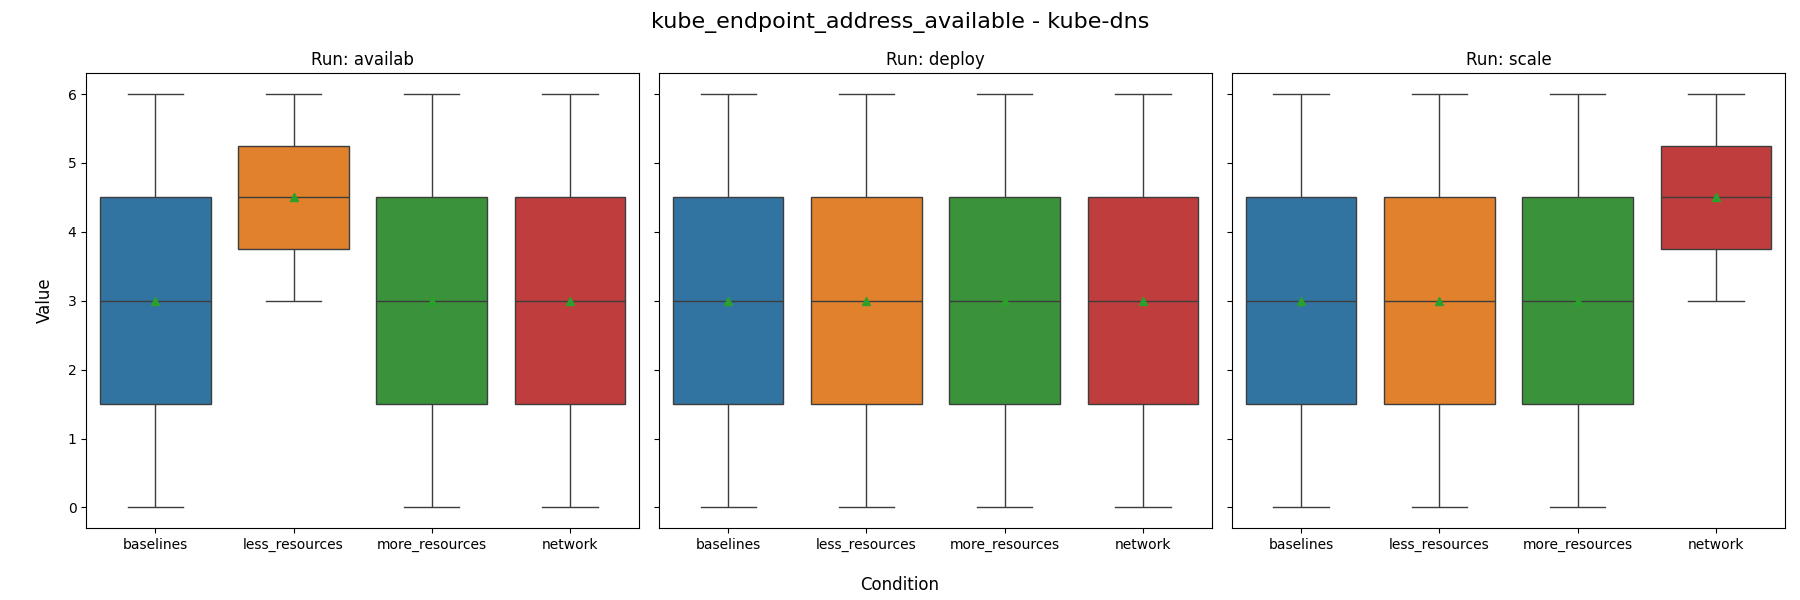

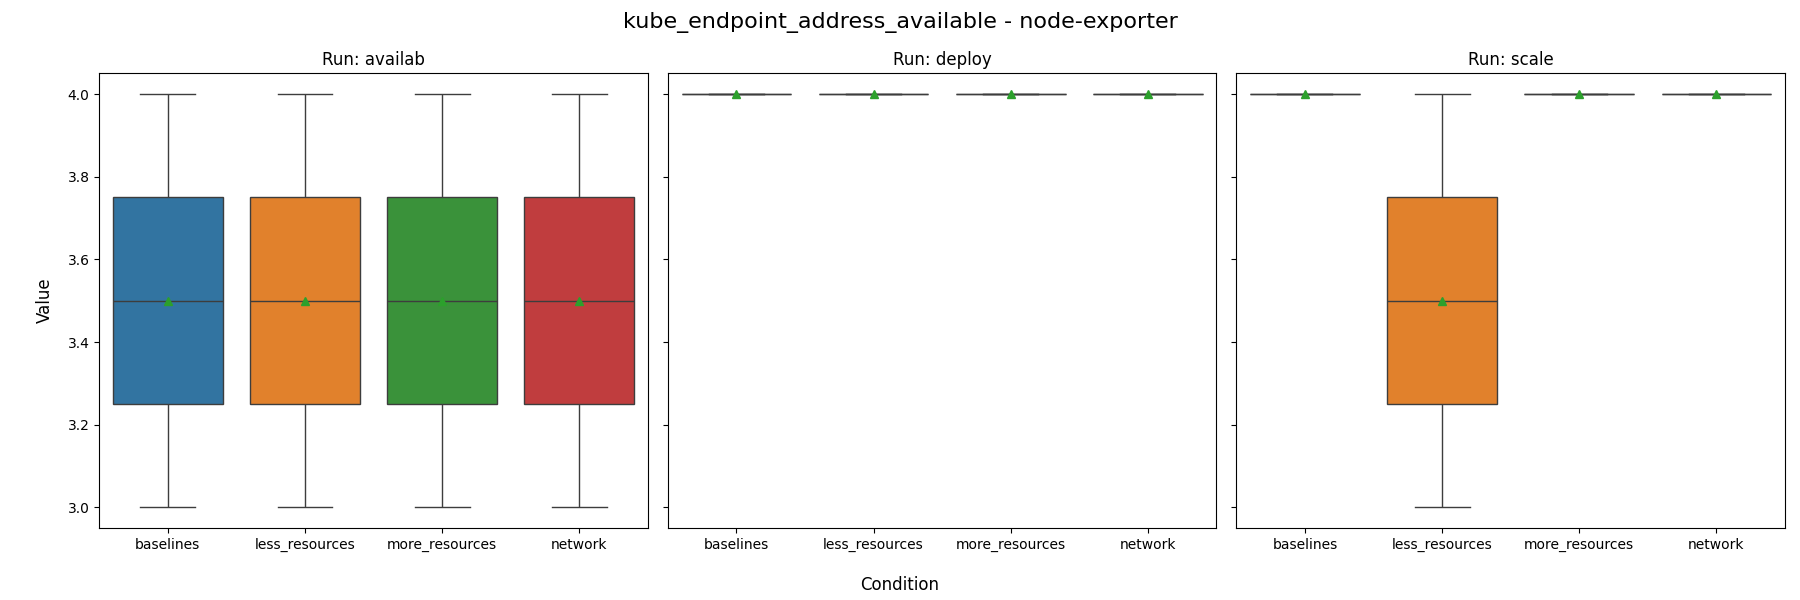

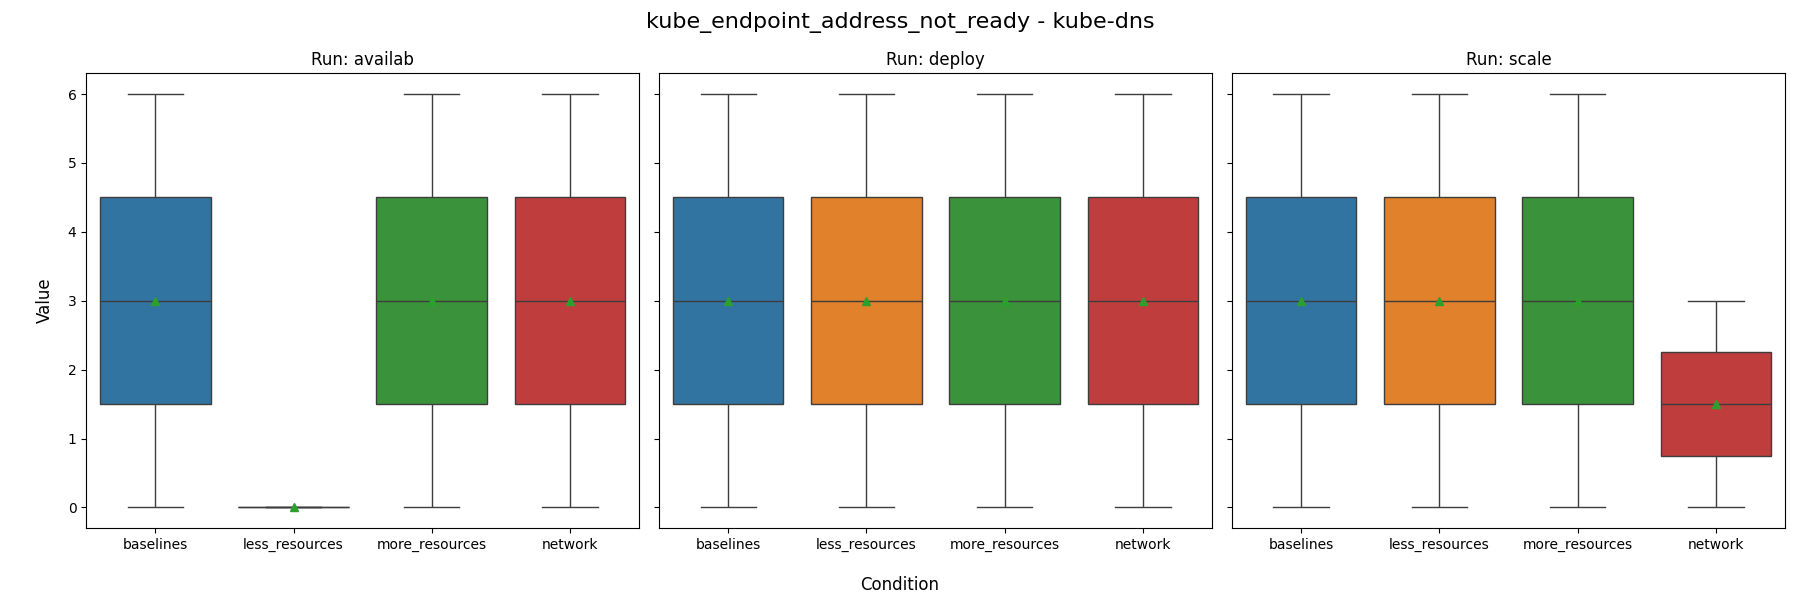

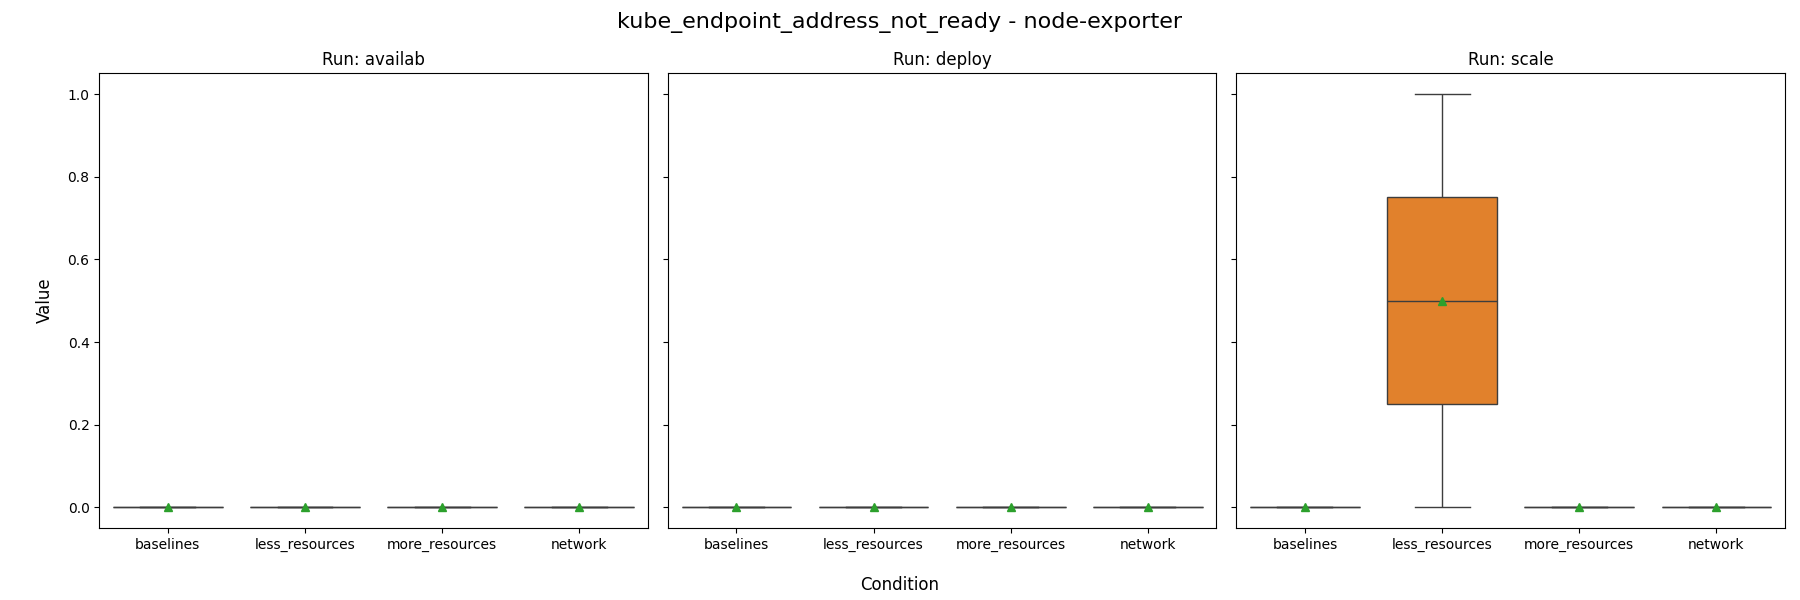

In [132]:
# Define desired metric names
metric_names = ['kube_endpoint_address_available', 'kube_endpoint_address_not_ready',]
split_by='endpoint'

wrong_endpoints = ["kbench-service-oid-0-tid-0", "kcench-service-oid-0-tid-0", "jbench-service-oid-0-tid-0", "nnde-exporter"]
endpoints_to_skip = ["prometheus-service", "kubernetes", "kube-state-metrics"] + wrong_endpoints

print_metrics(metric_names, split_by, endpoints_to_skip)

In [135]:
# Clean endpoints vars
del wrong_endpoints
del endpoints_to_skip

<h5>Replica sets</h5>

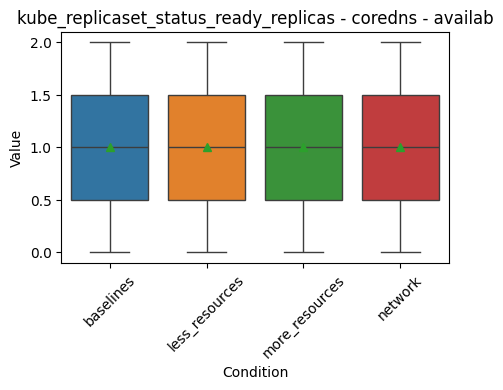

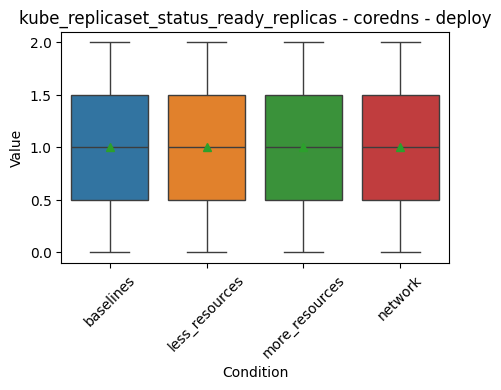

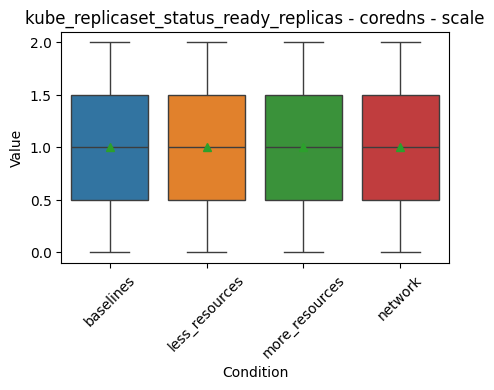

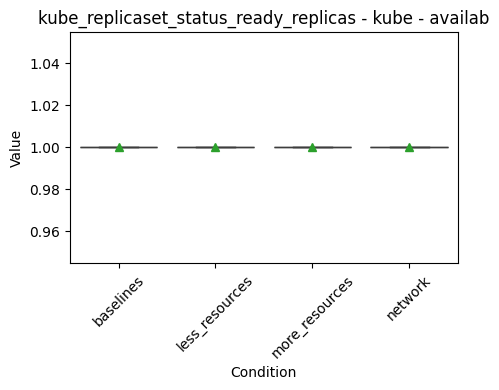

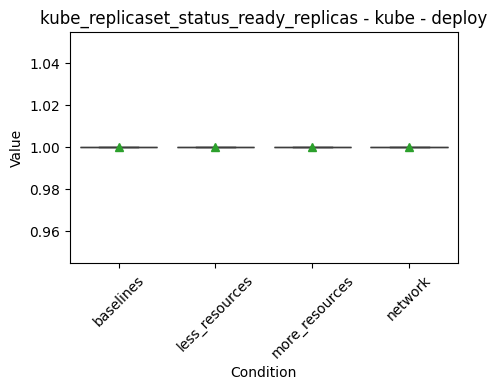

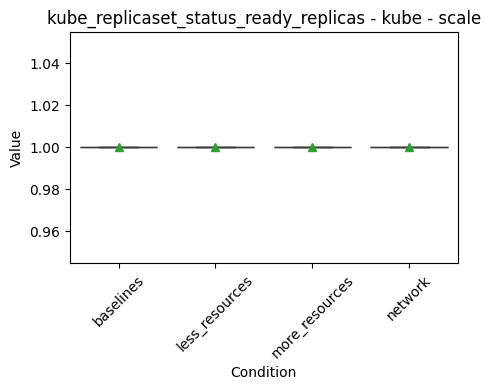

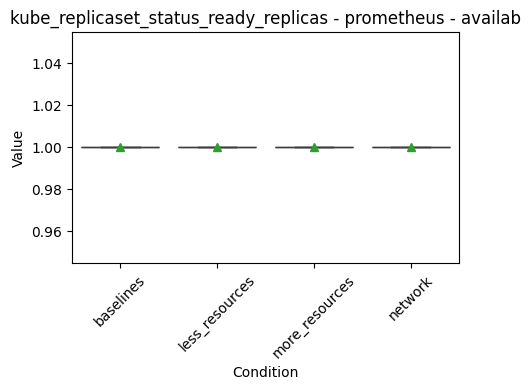

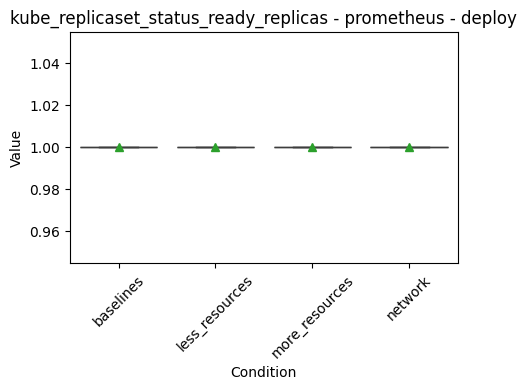

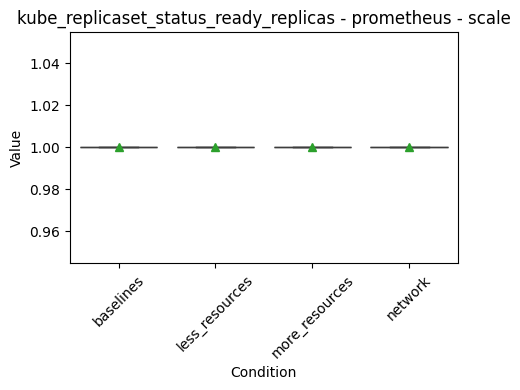

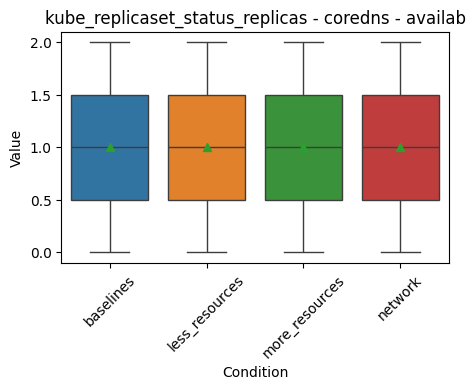

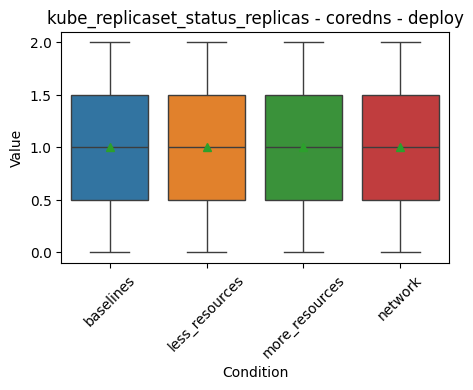

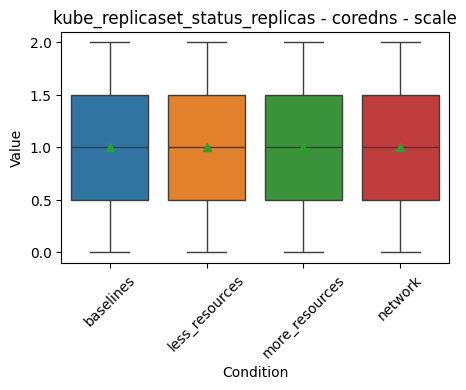

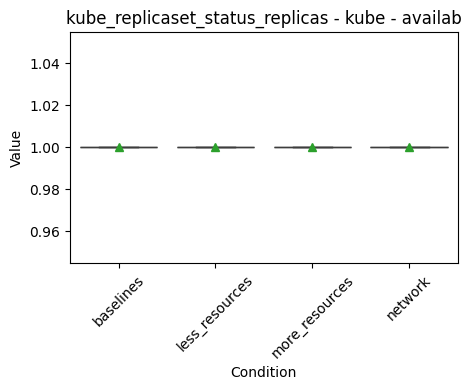

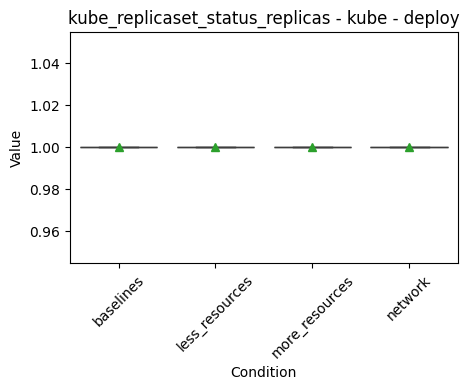

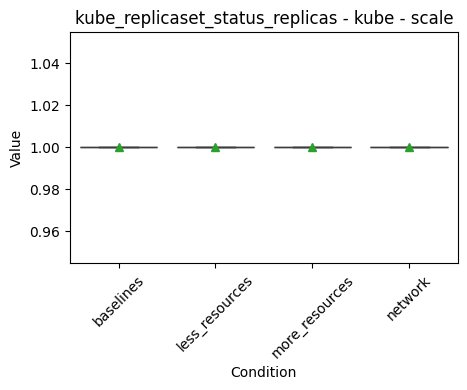

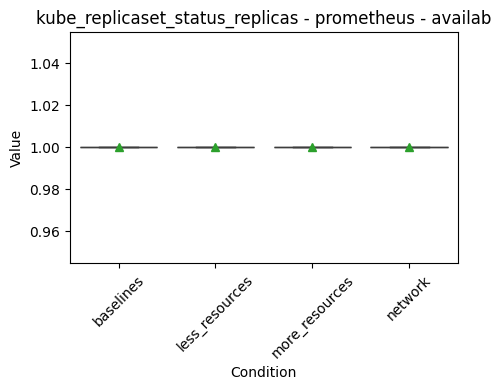

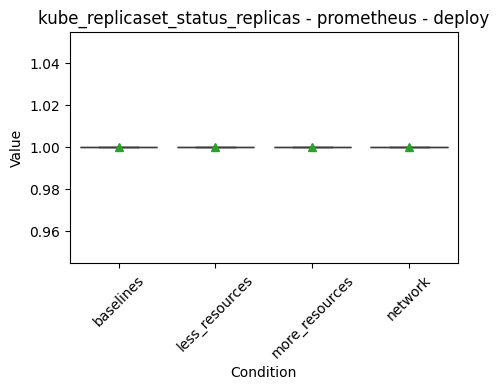

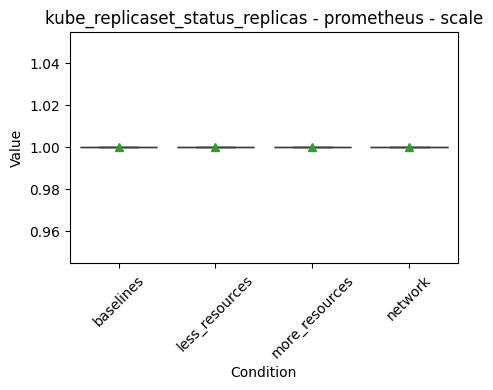

In [10]:
# Define desired metric names
metric_names = ['kube_replicaset_status_ready_replicas', 'kube_replicaset_status_replicas',]

split_by = 'replicaset'

wrong_rs = ["kbench", "kcench", "jbench", "nnde-exporter"]
rs_to_skip = ["prometheus-service", "kubernetes", "kube-state-metrics"] + wrong_rs

print_metrics(metric_names, split_by, rs_to_skip)

In [136]:
# Clean replcia set vars
del wrong_rs
del rs_to_skip

NameError: name 'wrong_rs' is not defined

<h5>Node file system bytes</h5>

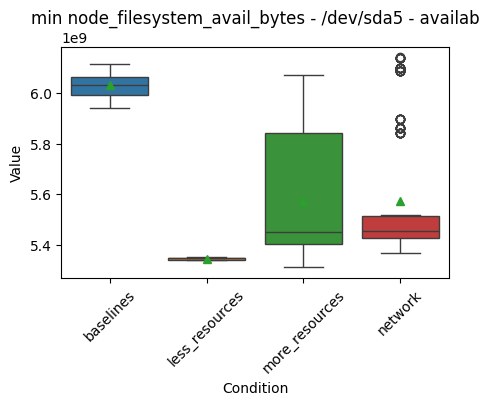

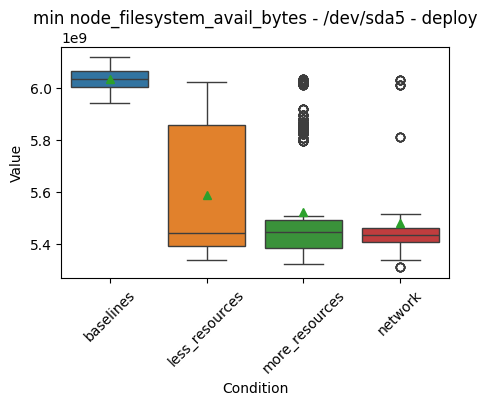

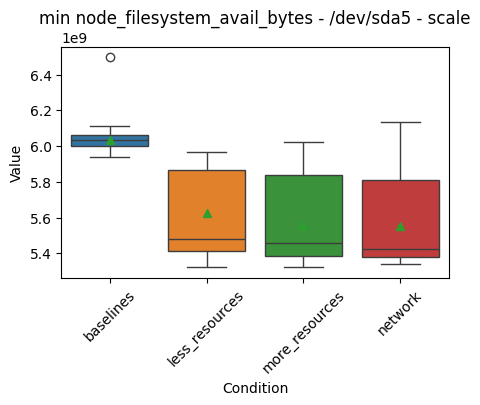

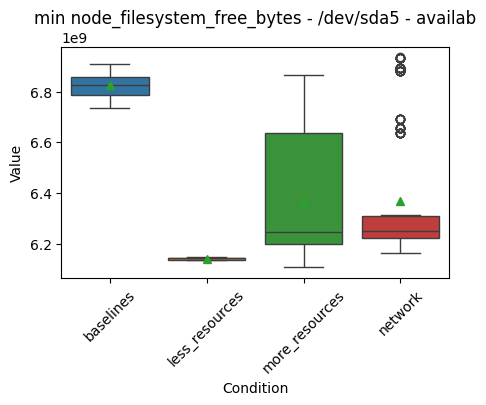

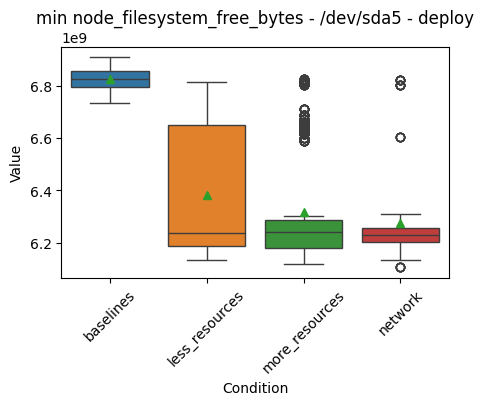

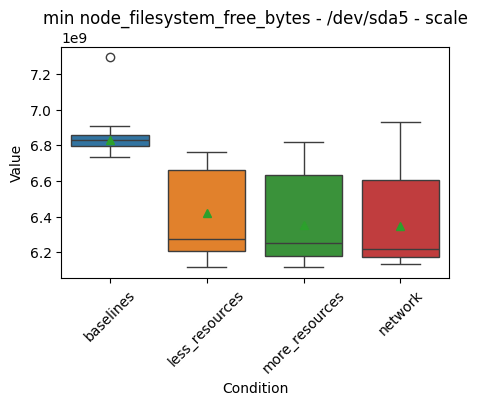

In [12]:
# Define desired metric names
metric_names = ['min node_filesystem_avail_bytes', 'min node_filesystem_free_bytes',]
split_by = 'device'
device_to_skip = ["tmpfs", "shm",] 

print_metrics(metric_names, split_by, device_to_skip)

In [137]:
# Clean node file system bytes
del device_to_skip

NameError: name 'device_to_skip' is not defined

<h4>node_filefd_allocated</h4>

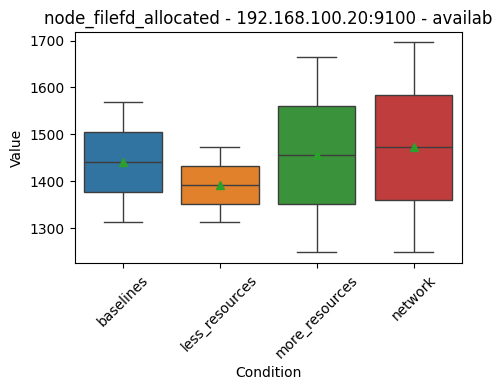

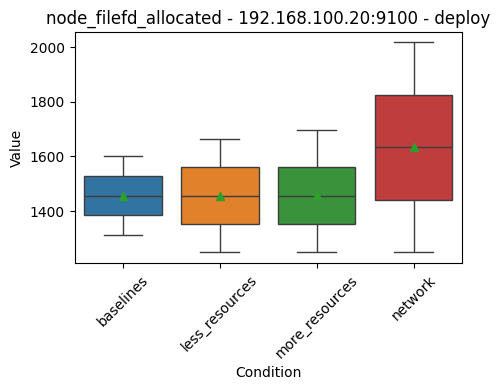

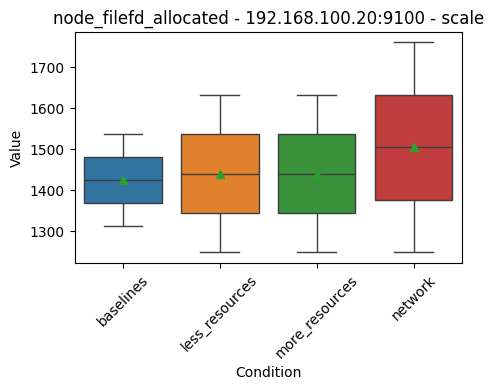

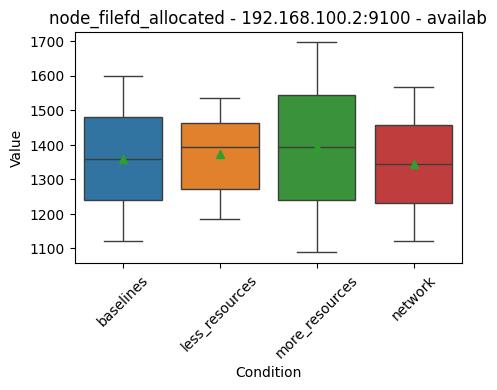

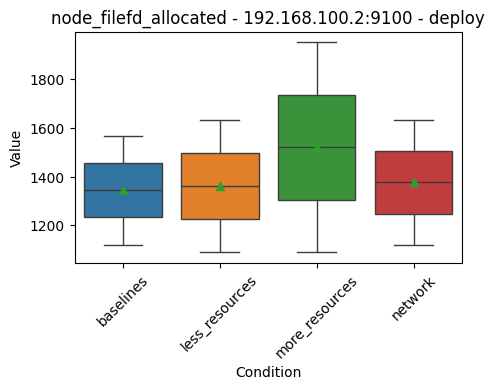

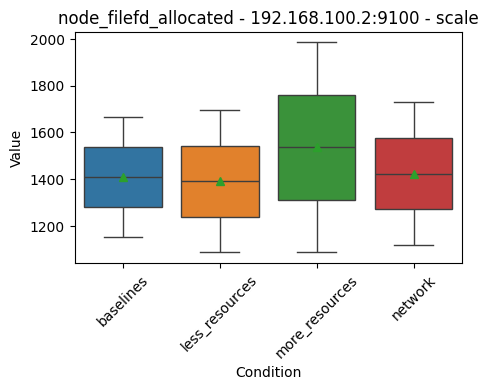

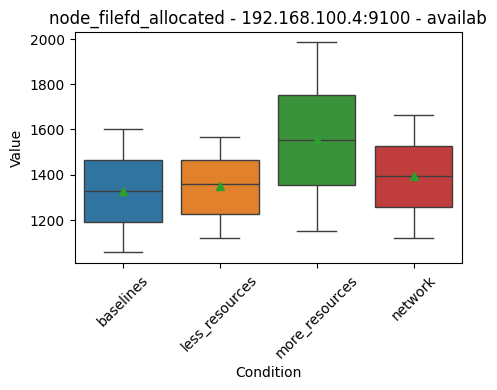

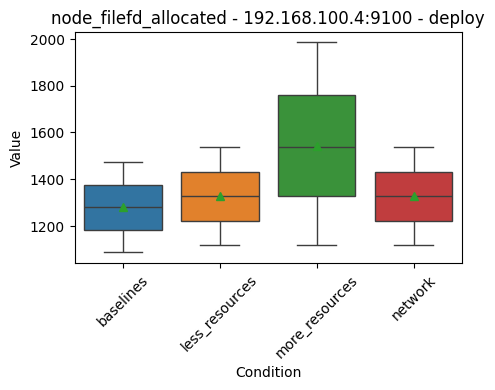

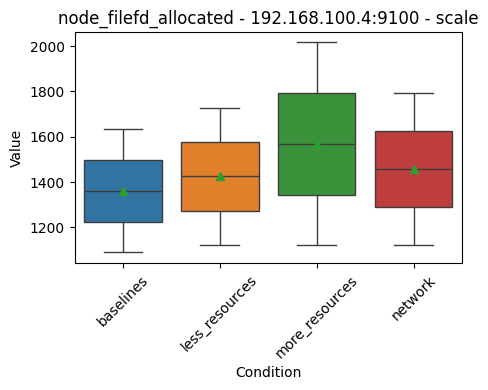

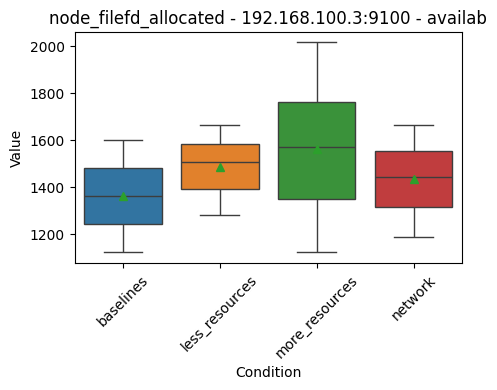

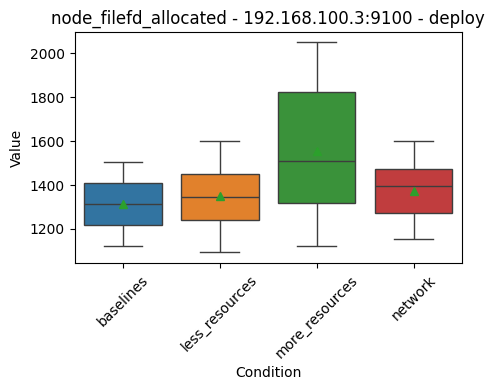

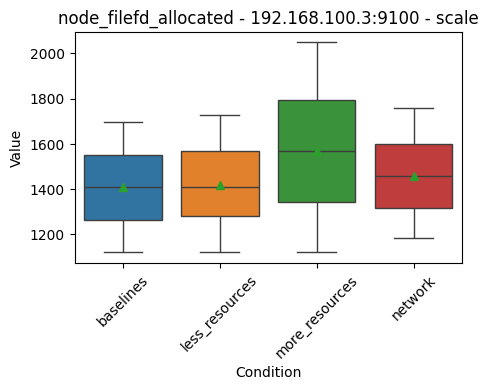

In [14]:
# Define desired metric names
metric_names = ['node_filefd_allocated',]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>node_load5<h4>

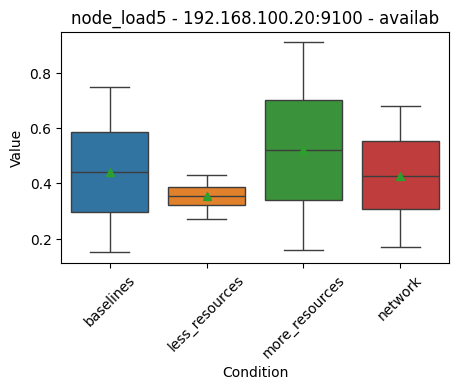

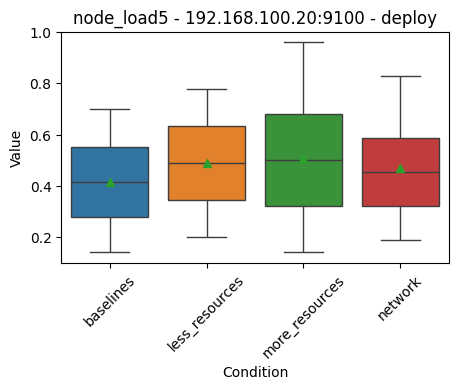

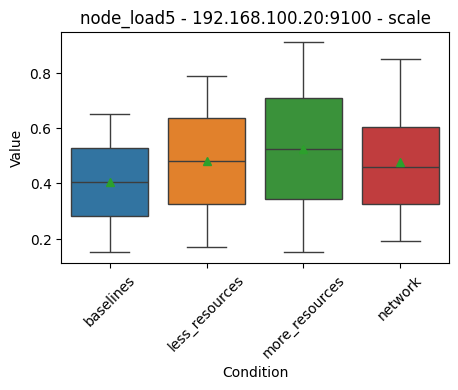

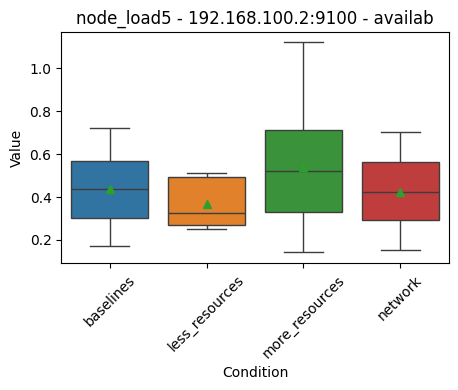

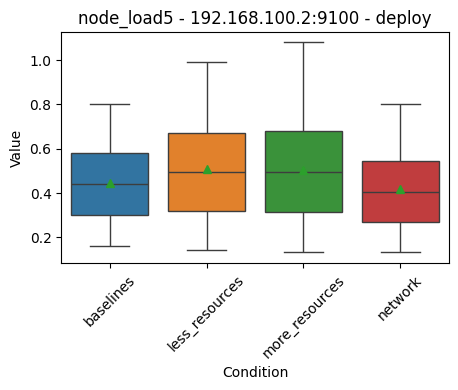

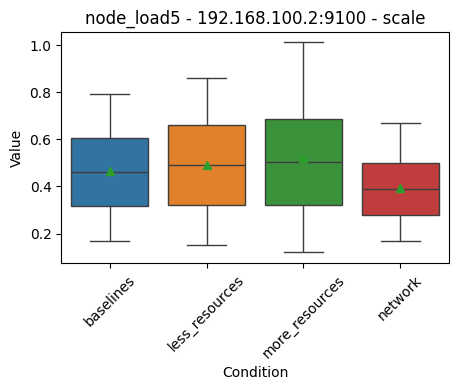

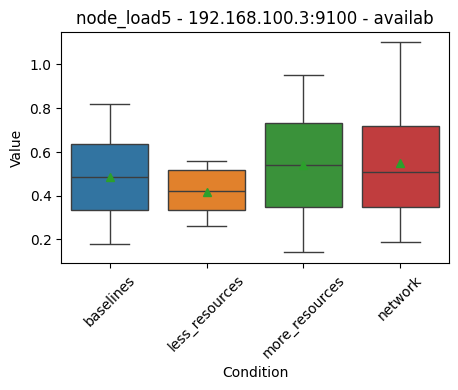

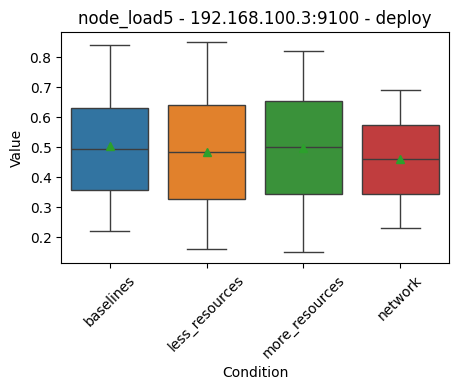

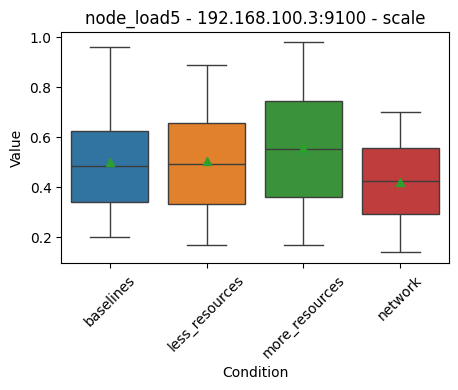

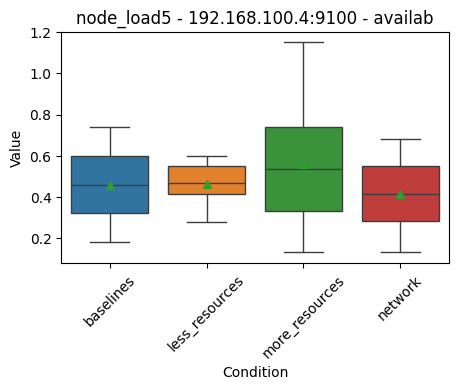

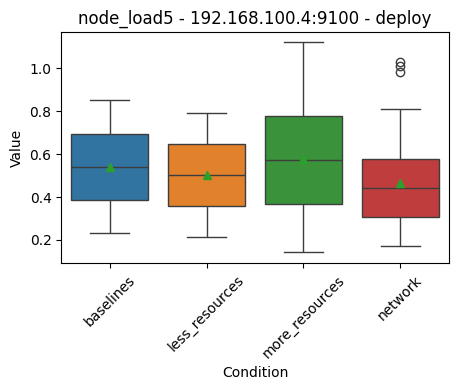

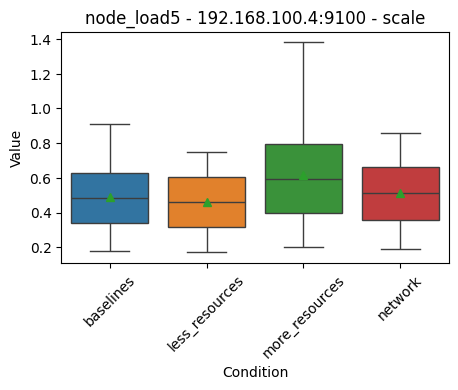

In [15]:
# Define desired metric names
metric_names = ['node_load5',]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>Node memory</h4>

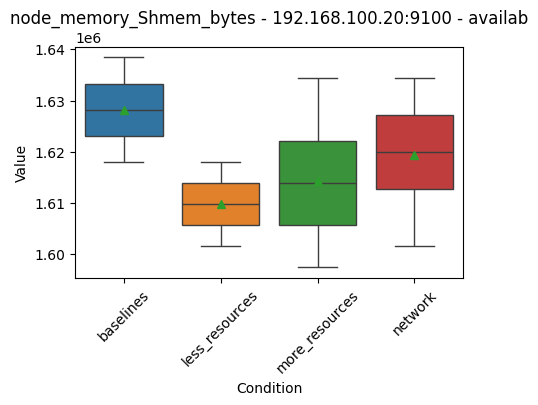

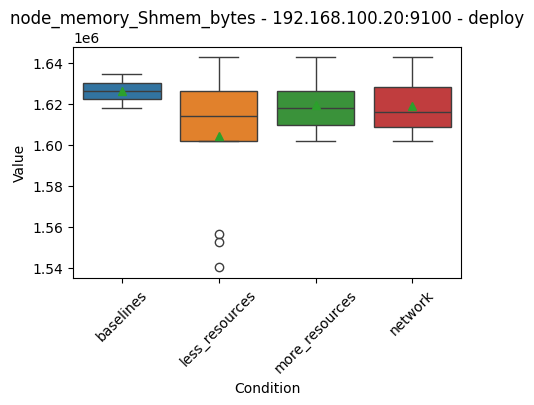

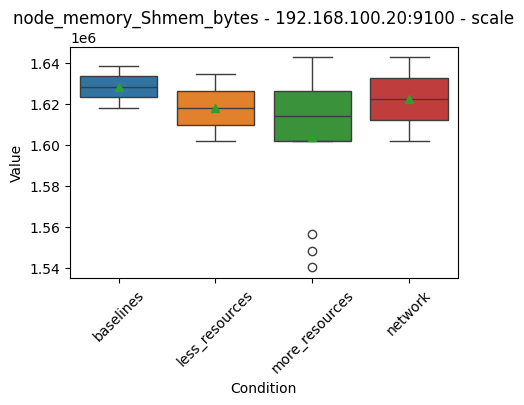

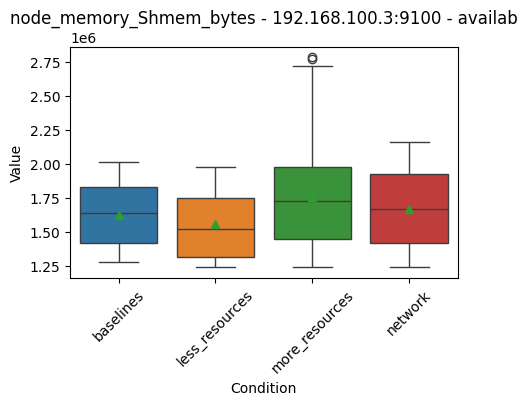

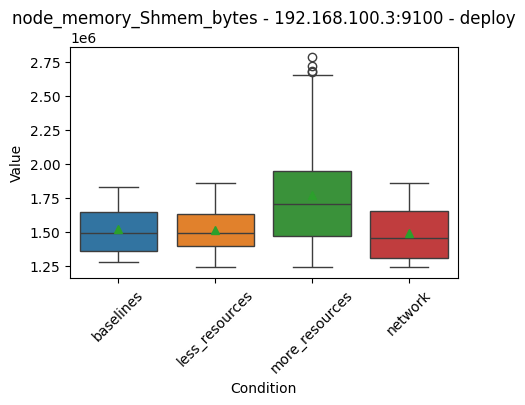

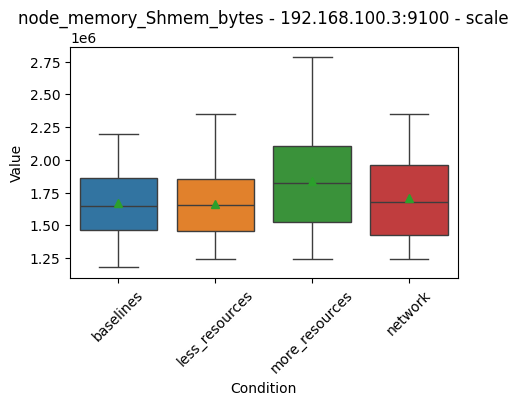

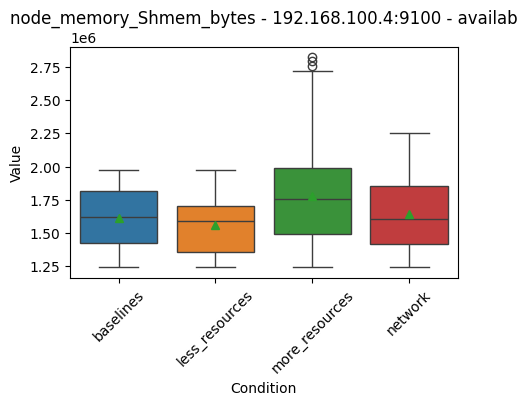

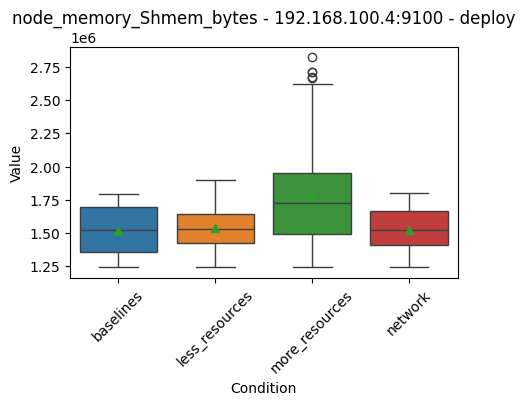

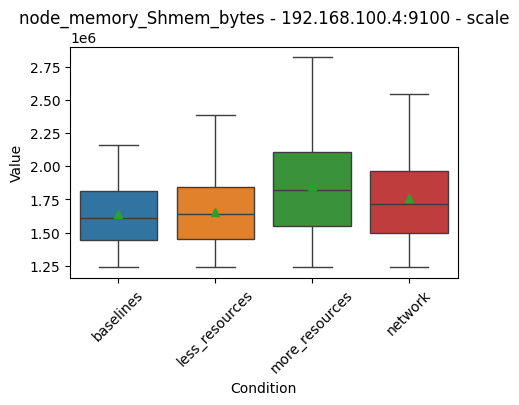

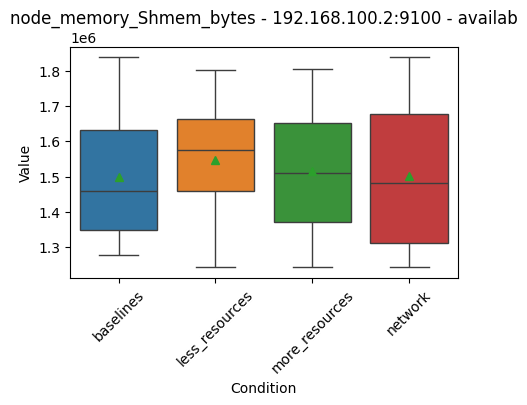

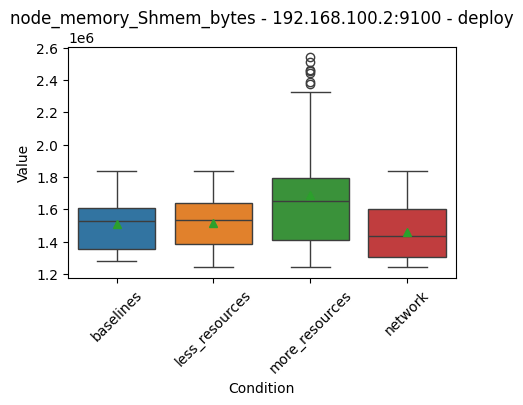

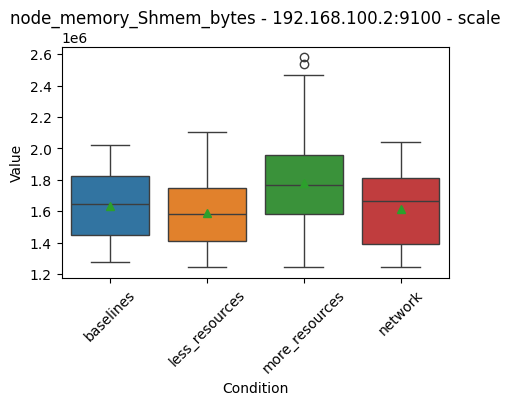

In [16]:
# Define desired metric names
metric_names_full = ["node_memory_Buffers_bytes", "node_memory_Cached_bytes", "node_memory_MemFree_bytes", "node_memory_Shmem_bytes", "node_memory_Slab_bytes", "node_memory_VmallocUsed_bytes"]
metric_names = ["node_memory_Shmem_bytes"]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>Node network stats</h4>

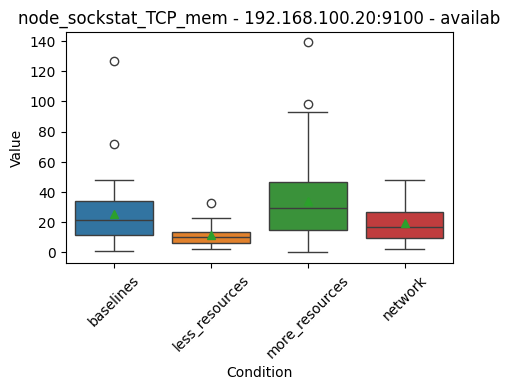

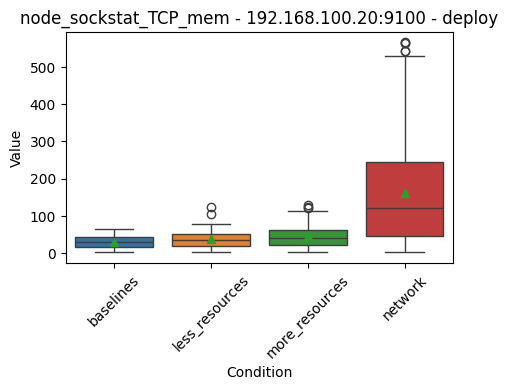

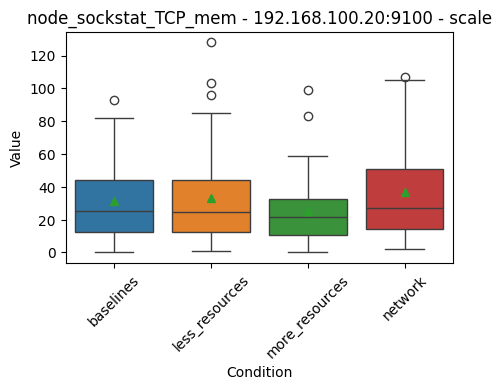

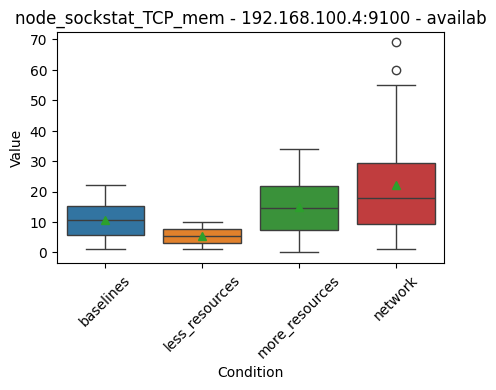

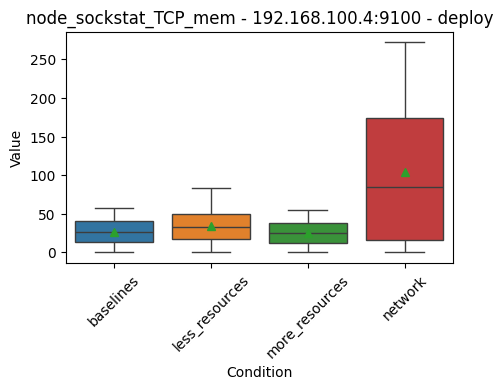

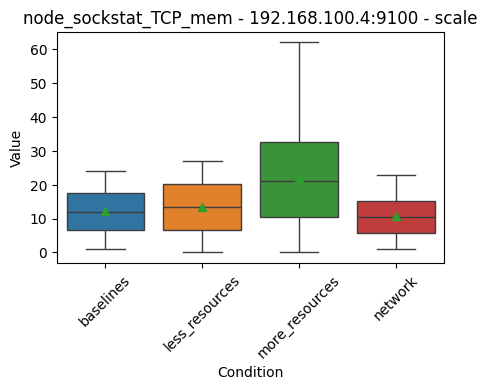

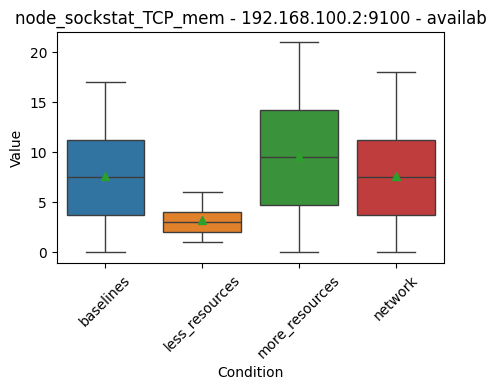

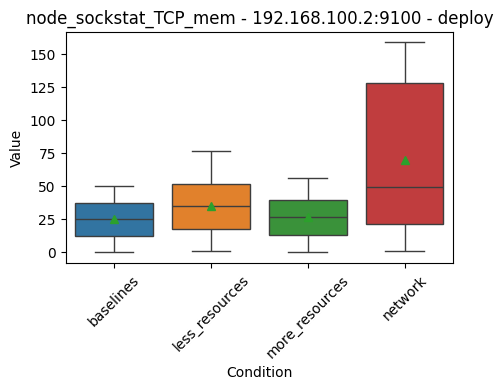

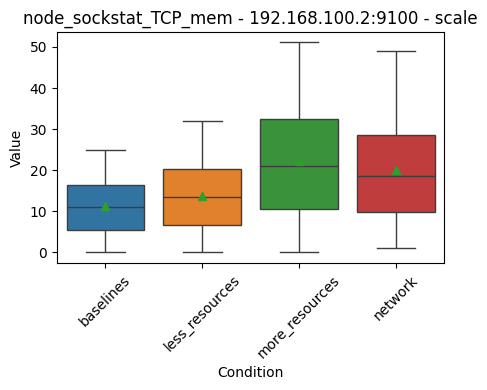

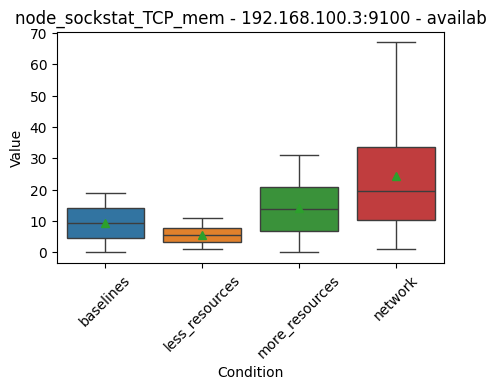

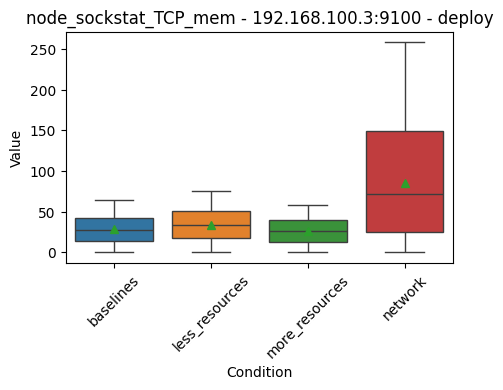

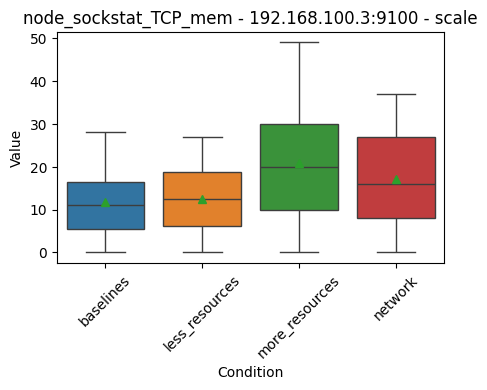

In [17]:
# Define desired metric names
metric_names_full = ["node_netstat_Tcp_CurrEstab", "node_procs_blocked", "node_sockstat_TCP_inuse", "node_sockstat_TCP_mem",]
metric_names = ["node_sockstat_TCP_mem"]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>Rates</h4>

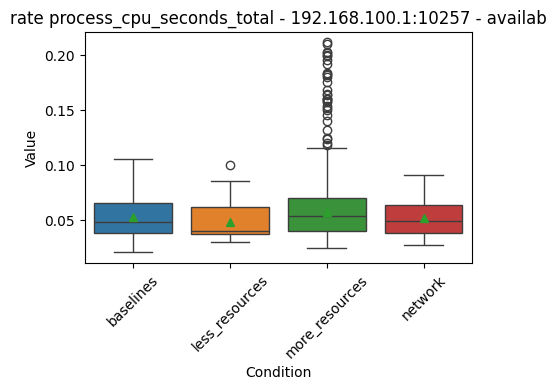

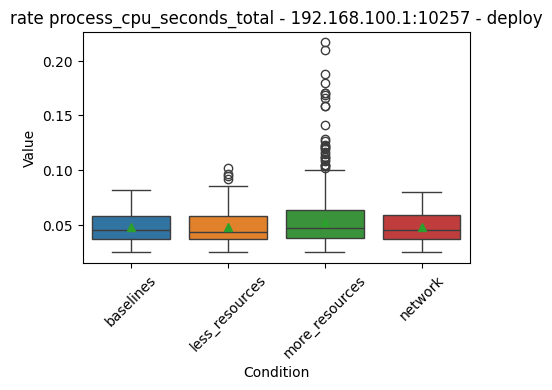

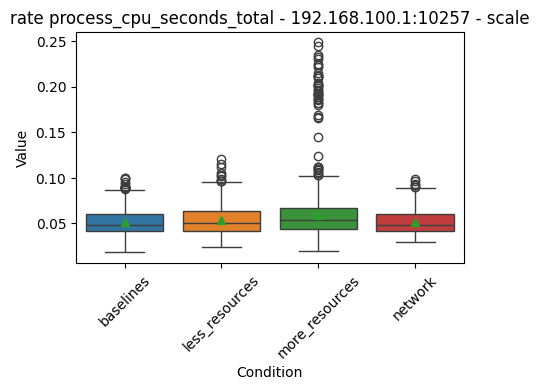

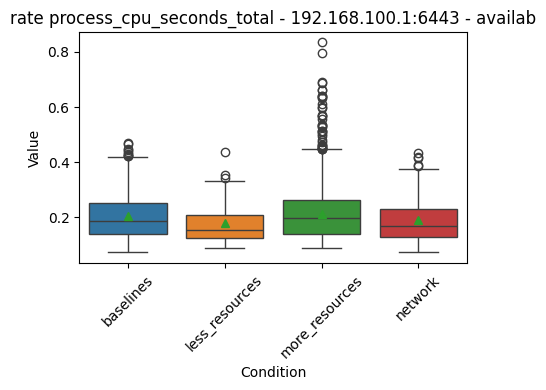

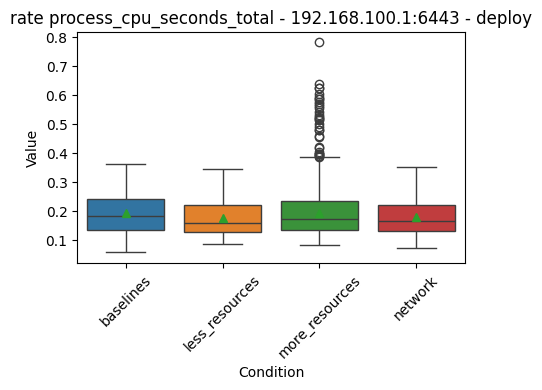

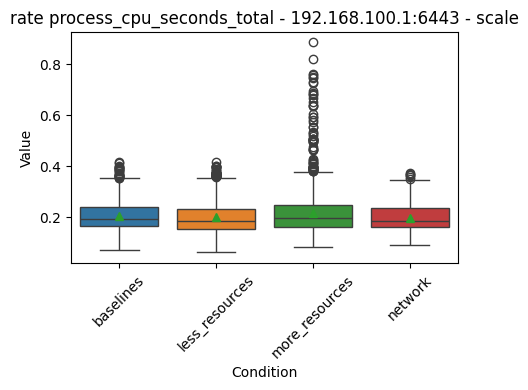

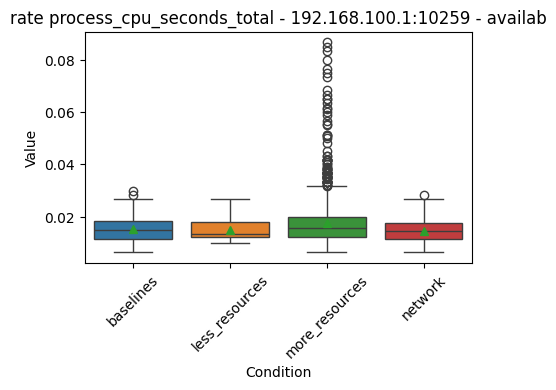

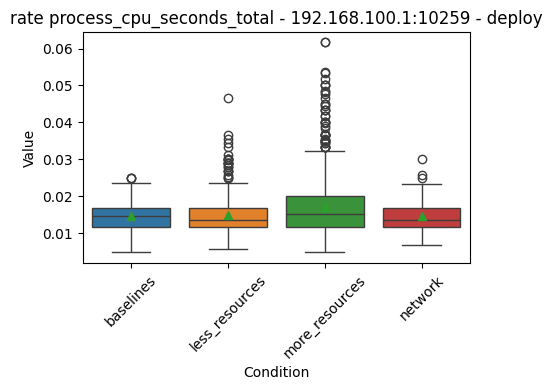

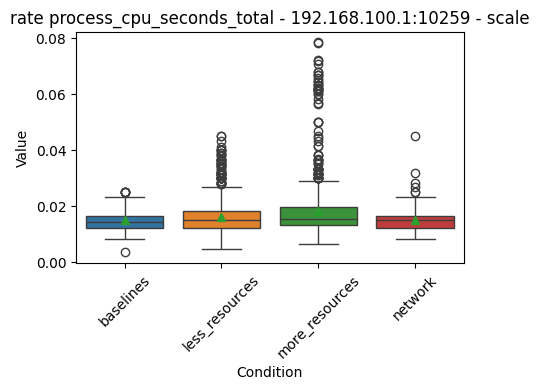

In [18]:
# Define desired metric names
metric_names_full = ["rate node_context_switches_total", "rate process_cpu_seconds_total", "rate process_resident_memory_bytes"]
metric_names = ["rate process_cpu_seconds_total"]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>Node status capacity</h4>

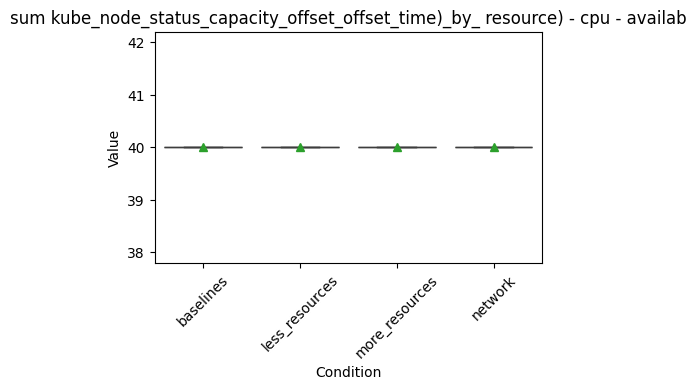

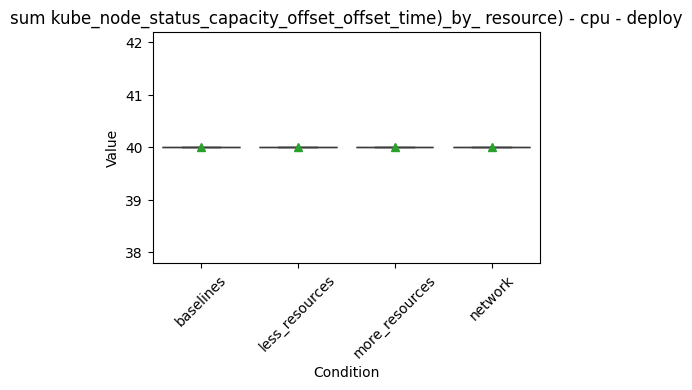

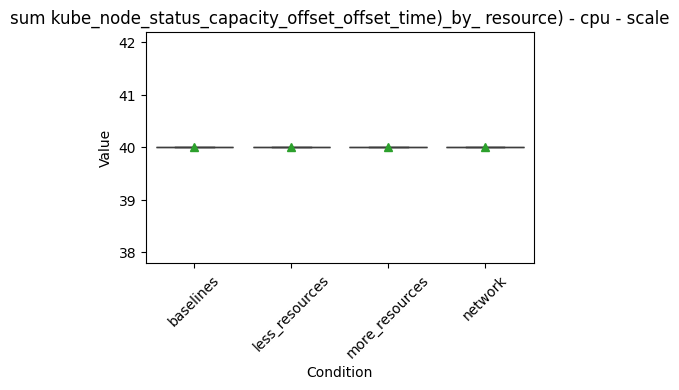

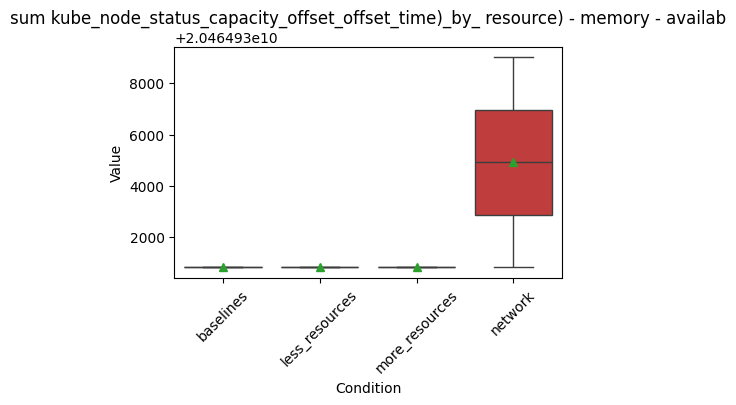

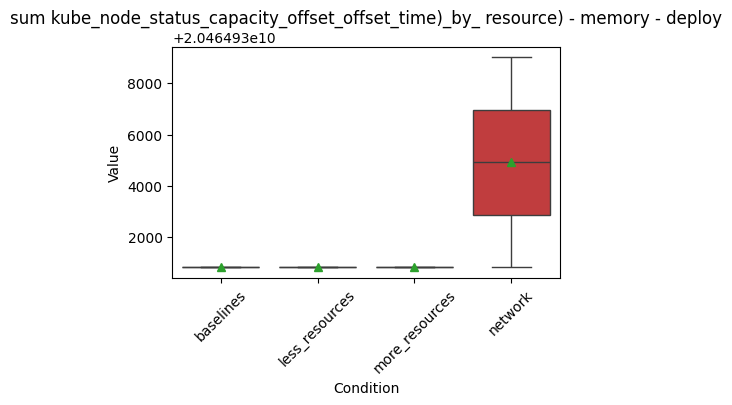

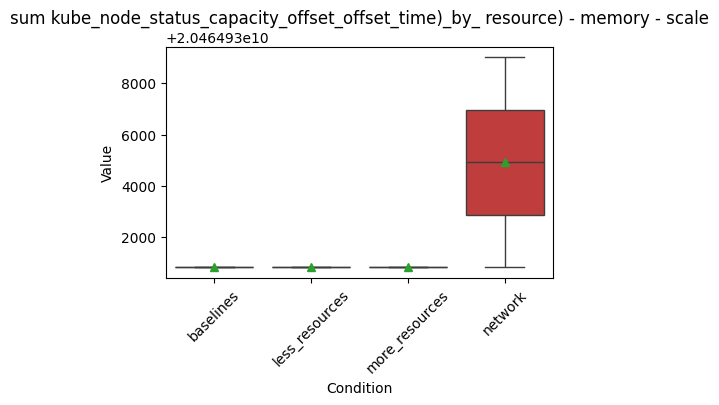

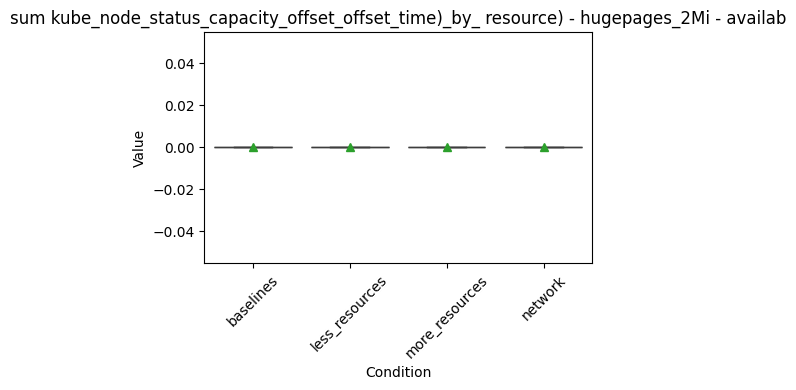

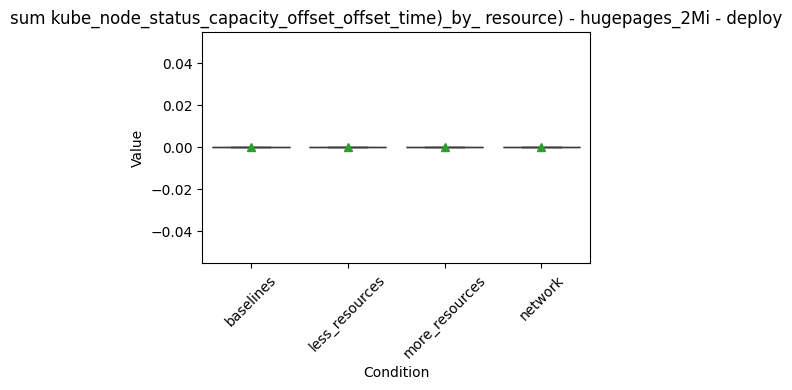

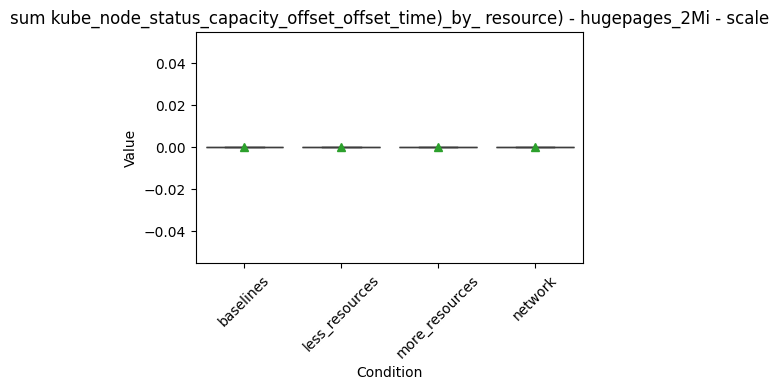

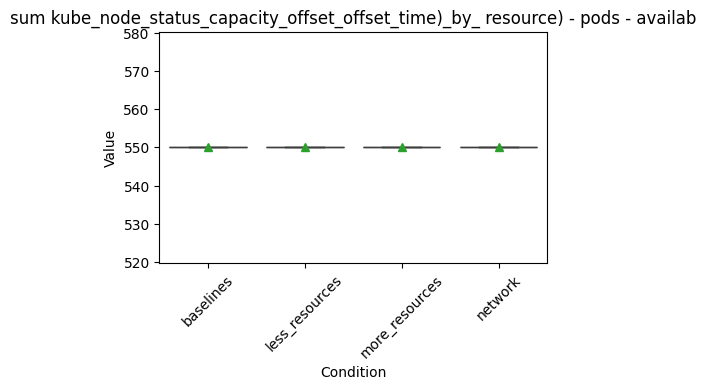

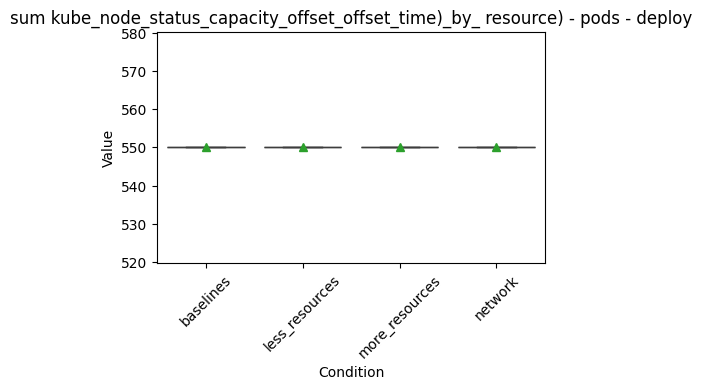

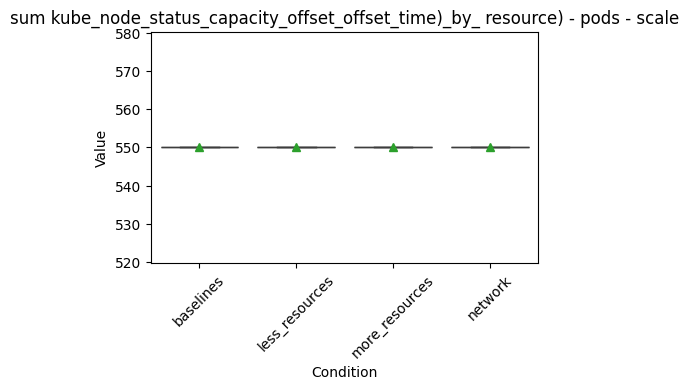

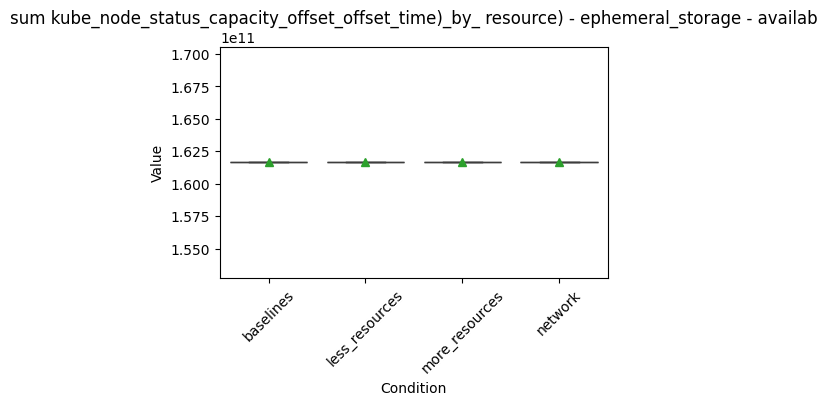

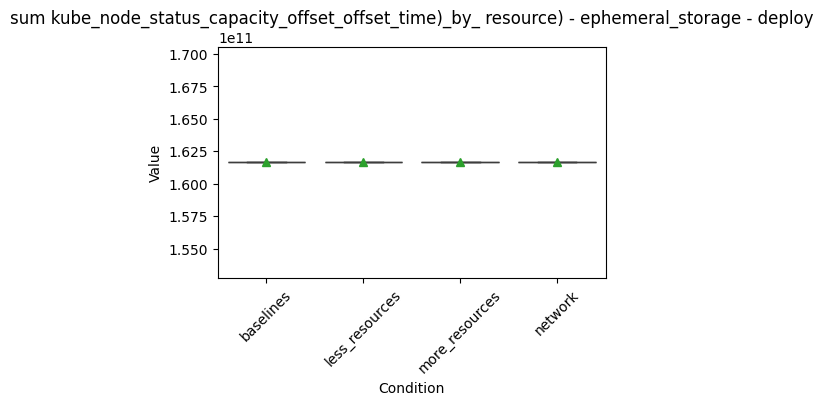

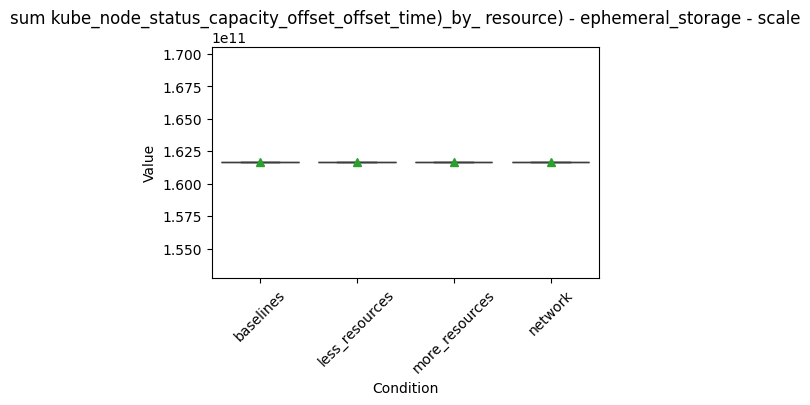

In [19]:
# Define desired metric names
metric_names = ["sum kube_node_status_capacity_offset_offset_time)_by_ resource)"]

split_by = 'resource'

print_metrics(metric_names, split_by, [])

<h4>Rate node network stats</h4>

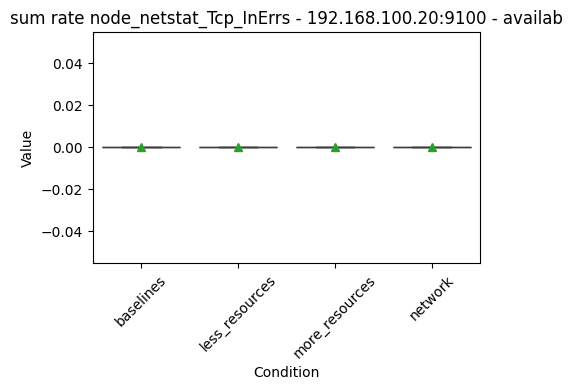

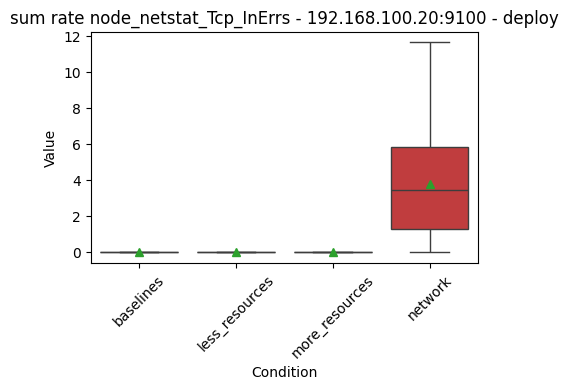

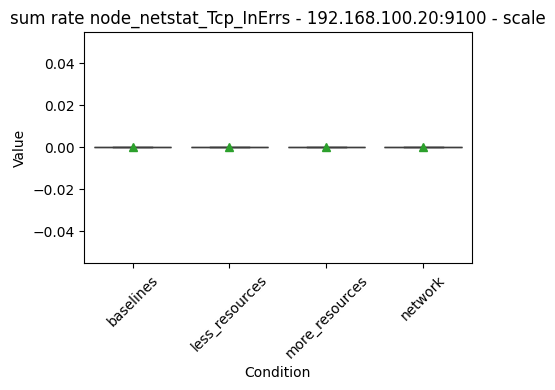

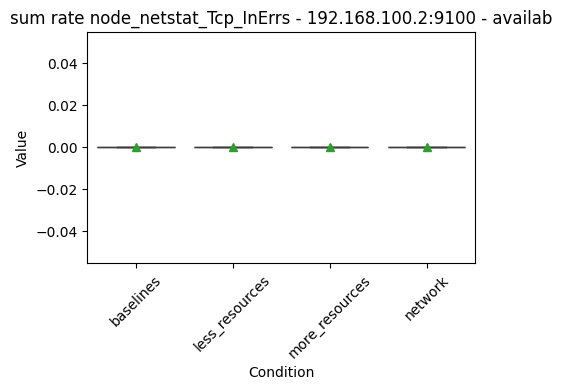

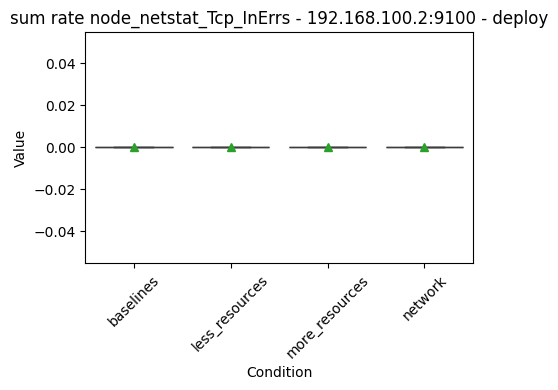

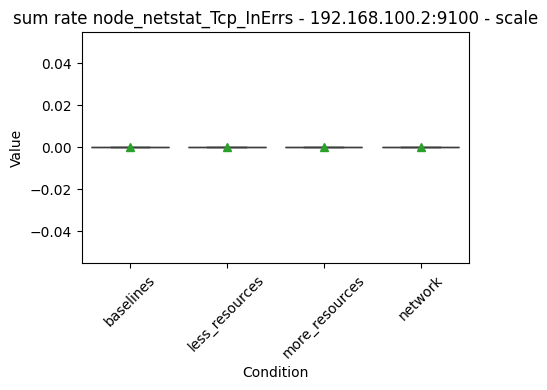

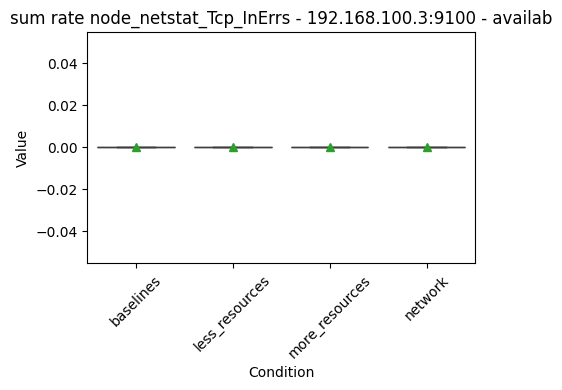

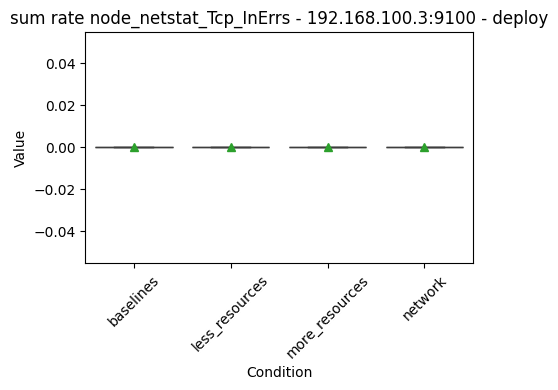

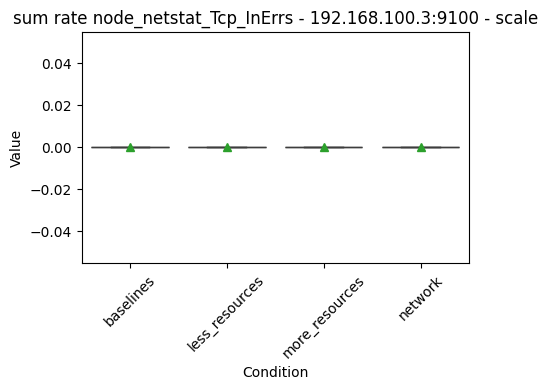

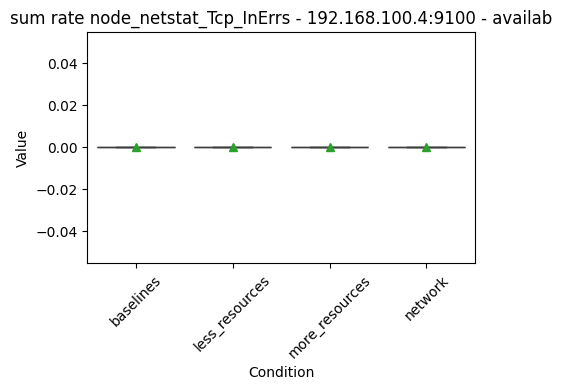

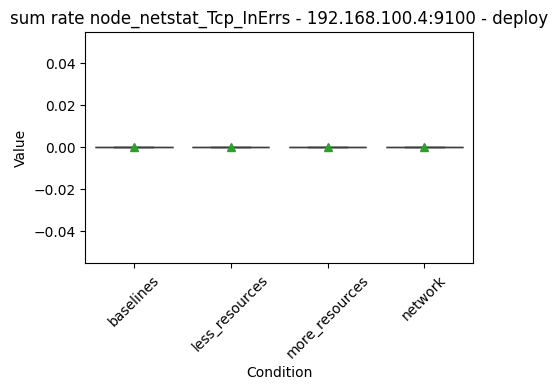

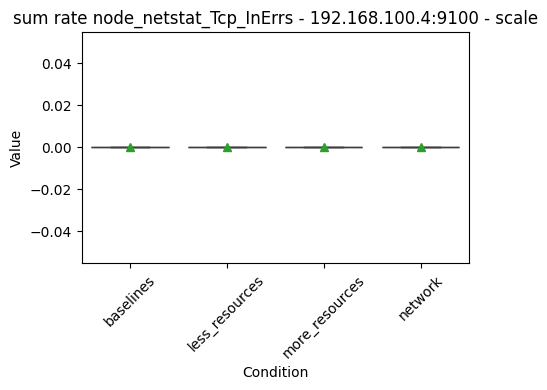

In [20]:
# Define desired metric names
metric_names_full = ["sum rate node_netstat_Tcp_InErrs", "sum rate node_netstat_Tcp_RetransSegs", "sum rate node_network_carrier_changes_total", "sum rate node_network_receive_packets_total", "sum rate node_network_transmit_packets_total"]
metric_names = ["sum rate node_netstat_Tcp_InErrs"]

split_by = 'instance'

print_metrics(metric_names, split_by, [])

<h4>Node work queue</h4>

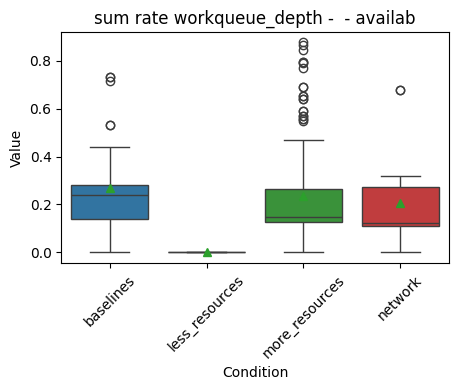

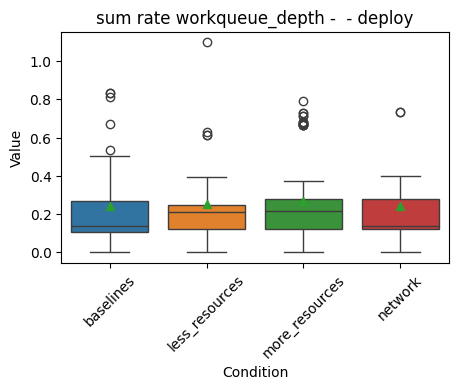

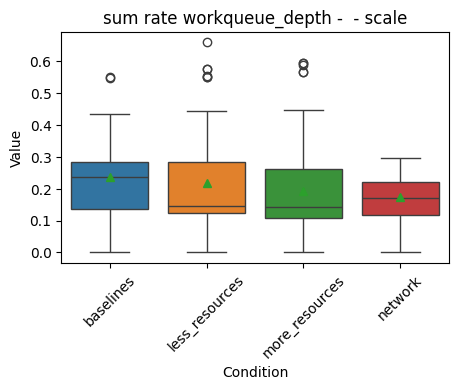

In [21]:
# Define desired metric names
metric_names_full = ["sum rate workqueue_adds_total", "sum rate workqueue_depth"]
metric_names = ["sum rate workqueue_depth"]

split_by = 'job'

# Filter DataFrame
df_filtered_by_name = df[df['name'].isin(metric_names)]

aggregated_df_splitted = df_filtered_by_name.groupby(['name', 'condition', 'run', 'value']).agg(
    mean_value=('value', 'mean')
).reset_index().sort_values("condition")
# kube_endpoint_address_not_ready - useless
for metric in metric_names:
    plot_metric_boxplot(aggregated_df_splitted, metric, f"{metric} - ")

<h3>Histograms</h3>

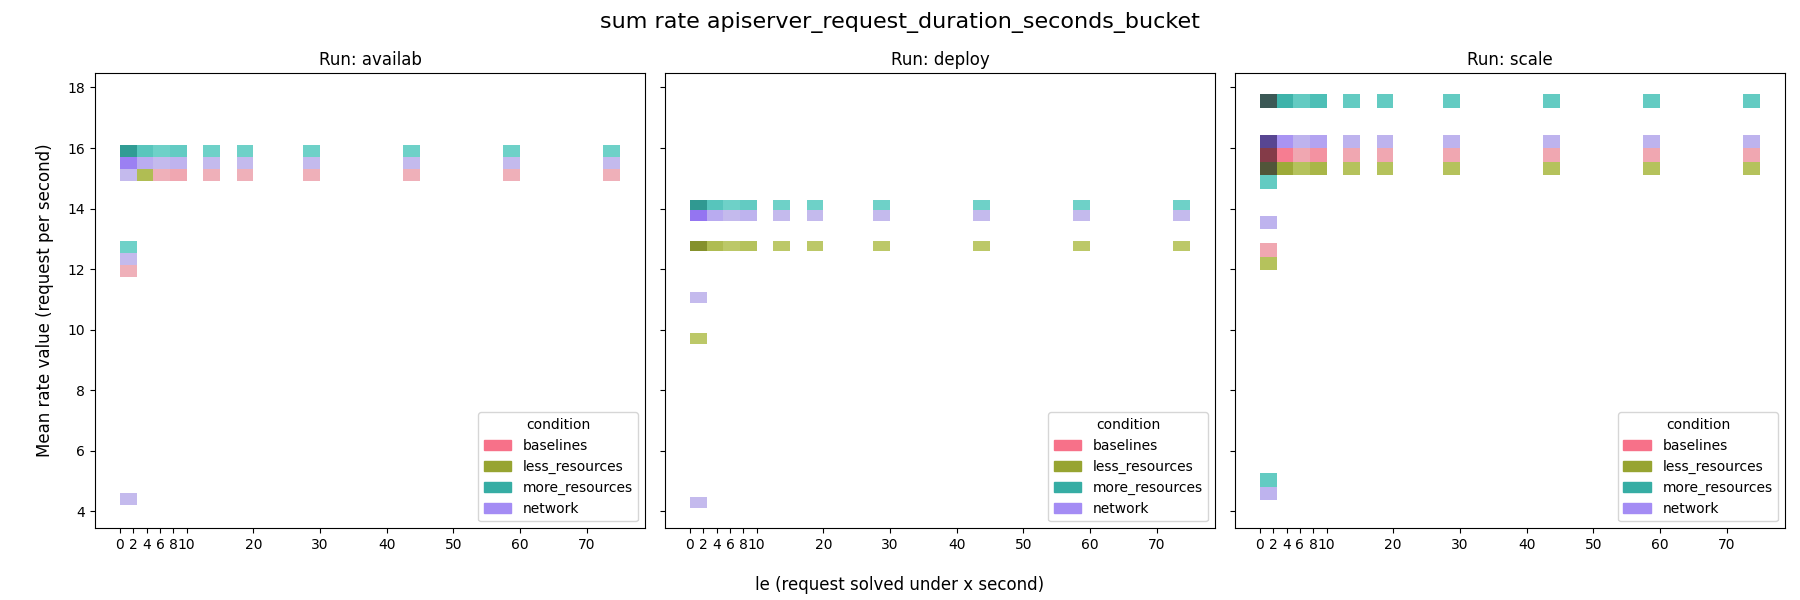

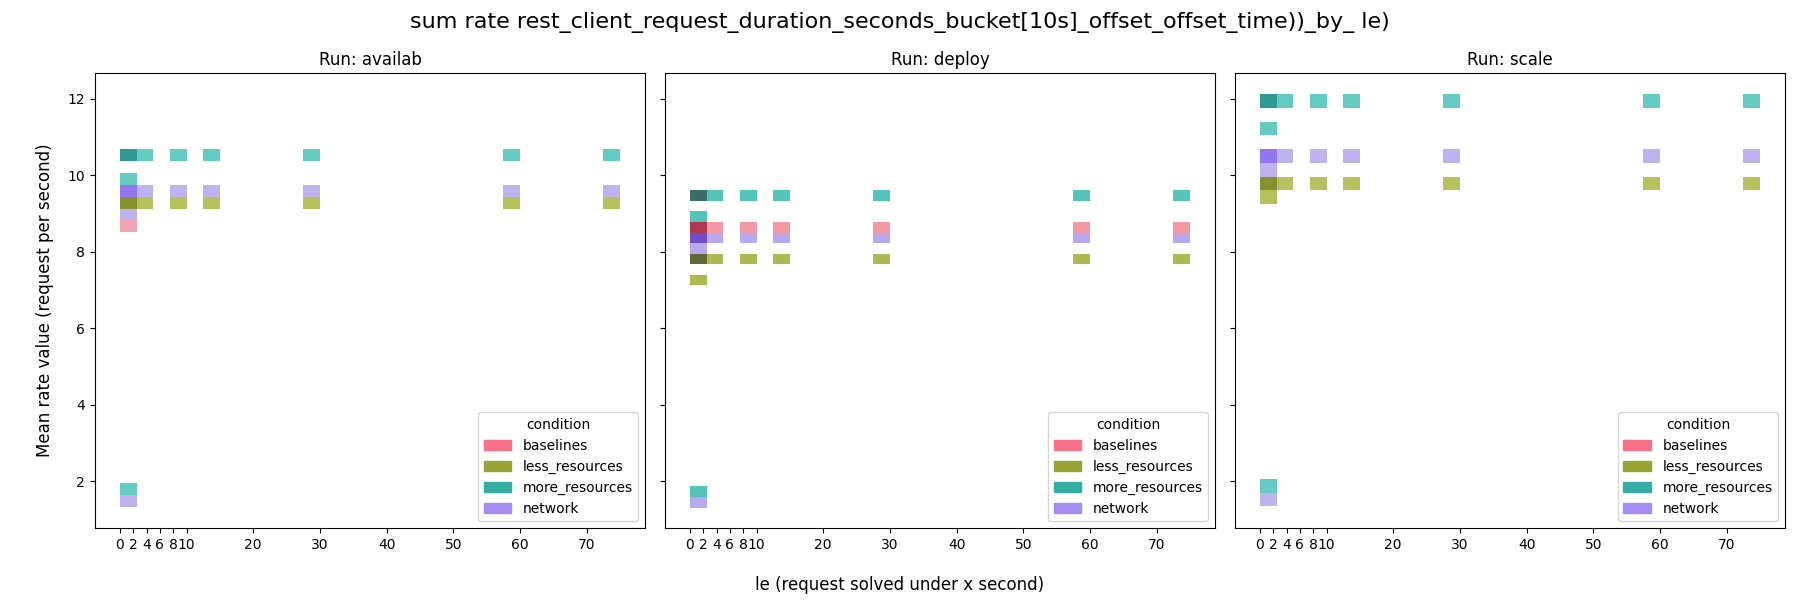

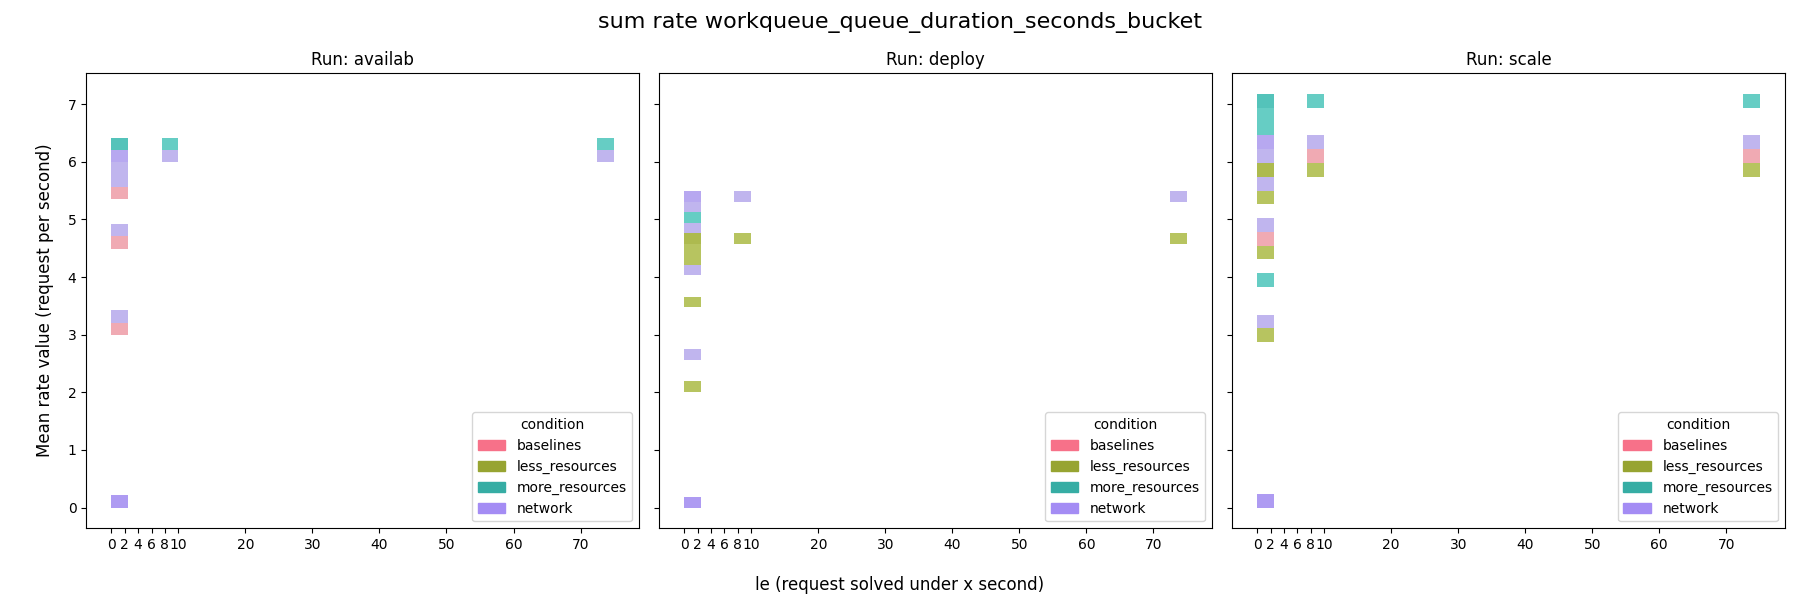

In [133]:


metric_names = ["sum rate apiserver_request_duration_seconds_bucket", "sum rate rest_client_request_duration_seconds_bucket[10s]_offset_offset_time))_by_ le)", "sum rate workqueue_queue_duration_seconds_bucket"]

df_filtered_by_name = df[df['name'].isin(metric_names)]
df_grouped = df_filtered_by_name.groupby(['name', 'le', 'condition', 'run']).agg(
        mean_value=('value', 'mean')
).reset_index().sort_values("le").sort_values("condition")

for metric_name in metric_names:

        # Create subplots: 1 row and 3 columns (for the three runs)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Iterate through each run and corresponding subplot axis
        for i, run in enumerate(["availab", "deploy", "scale"]):
                # Filter the DataFrame for the specific run and create a copy
                filtered_df = df_grouped[df_grouped['run'] == run].copy()
                filtered_df = filtered_df[filtered_df['name'] == metric_name].copy()

                # Replace +Inf with a large finite value using .loc[]
                filtered_df.loc[filtered_df['le'] == float('inf'), 'le'] = 75

                # Filter by le value if necessary
                # filtered_df = filtered_df[filtered_df['le'] < 61]

                # Plotting the occurrence (frequency) histogram for all conditions in the same subplot
                ax = sns.histplot(x='le', y='mean_value', data=filtered_df, bins=30, hue='condition', palette="husl", ax=axes[i])
                axes[i].set_title(f'Run: {run}')
                axes[i].set_xlabel('')
                axes[i].set_ylabel(' ')
                ticks = np.concatenate((np.arange(0, 10, step=2), np.arange(10, 71, step=10)))
                # ticks = np.concatenate(np.arange(0, 10.1, step=0.5), np.arange(10.1, 70, step=10))
                ax.set_xticks(ticks)
                # axes[i].xticks(ticks)
                sns.move_legend(ax, "lower right")

        # Set the shared y-label
        fig.supylabel('Mean rate value (request per second)')
        fig.supxlabel('le (request solved under x second)')
        fig.suptitle(metric_name, fontsize=16)
        fig.set_label(" ")
        # Adjust the layout for better spacing
        plt.tight_layout()
        plt.show()


In [134]:
del ticks
del ax
del fig
del axes
del df_grouped
del df_filtered_by_name

<h4> ALL FIELDS </h4>

In [23]:
# print(field_group)
print_all = False

if print_all:
    for label, content in field_group.items():
        for metric in content:
            if not metric.isnumeric():
            
                print(f"\n{metric}")
                try:
                    # plot_metric_violin(df, metric)
                    plot_metric_boxplot(df, metric)
                except Exception as e:
                    print(e)
                    continue